In [1]:
import pandas as pd
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
from statannot import add_stat_annotation
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from matplotlib.lines import Line2D
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests


def return_chop_seq(seq, list_of_slices):
    new_seq = []
    for slc in list_of_slices:
        new_seq.append(seq[slc[0]:slc[1]])
    new_seq_string = ''.join(new_seq)
    return new_seq_string
# print(len("abcdefghijklmnop"))
# print(return_chop_seq("abcdefghijklmnop", [(0,4), (8,12)]))
# print(return_chop_seq("abcdefghijklmnop", []))

def combine_dicts(dicts_list):
    combined_dict = {}
    for dictionary in dicts_list:
        for key, value in dictionary.items():
            if key in combined_dict:
                combined_dict[key].append(value)
            else:
                combined_dict[key] = [value]
    return combined_dict

def count_consecutive_stretches_of_1(lst):
    count = 0
    current_stretch = False
    start_stop_list = []
    for index, num in enumerate(lst):
        if num == 1:
            if current_stretch == False:
                start = index
                current_stretch = True
                count += 1
        else:
            if current_stretch == True:
                current_stretch = False
                stop = index
                start_stop_list.append((start, stop, "IDR"))
    if current_stretch == True:
        start_stop_list.append((start, len(lst), "IDR"))
    return start_stop_list

def is_either_between(low_range, high_range, a, b):
    return (low_range <= a <= high_range) or (low_range <= b <= high_range)

# def is_either_between(low_range, high_range, a, b):
#     return (low_range <= a <= high_range) or (low_range <= b <= high_range)
def assign_group(protein, group1_name: list, group1_string, group2_name: list, group2_string ):
    if protein in group1_name:
        return group1_string
    elif protein in group2_name:
        return group2_string
    else:
        return 'Not in any group'


def assign_group_4(protein, group1_name: list, group1_string, group2_name: list, group2_string, group3_name: list, group3_string ,group4_name: list, group4_string  ):
    if protein in group1_name:
        return group1_string
    elif protein in group2_name:
        return group2_string
    elif protein in group3_name:
        return group3_string
    elif protein in group4_name:
        return group4_string
    else:
        return 'Not in any group'


def create_boxplot_with_dots(data, hue_order, scatter=True, **kwargs):
    # num_of_hues = len(hue_order)
    # # print(num_of_hues)
    # Create boxplots for the two groups
    fig = plt.figure(figsize=(12, 6))

    # sns.boxplot(data=df, y=metric, x='Group', color='blue', width=0.5, showfliers = False, order=["pos", "neg"])
    ax = sns.boxplot(data=data, y='data', x='Group', hue='metric' ,width=0.8, order=["pos", "neg"], hue_order= hue_order, showfliers = False, ax=plt.gca(), zorder=5, **kwargs) # 
    if scatter:
        sns.stripplot(data=data, y='data', x='Group', hue="metric", color='black', order=["pos", "neg"], hue_order= hue_order, size=5, jitter=0.1, alpha=0.3, dodge=True, zorder=10) 
        # cat_mapping = {k:i for i,k in enumerate(list(data["Group"].unique())) }
        # for i, metr in enumerate(hue_order):
        #     print(metr)
        #     red_data = data[data['metric'] == metr]
        #     # red_data['Group'] = [cat_mapping[cat] - 0.1 for cat in red_data['Group']]
        #     print(red_data)
        #     sns.stripplot(data=data, y='data', x='Group', hue="metric", color='black', order=["pos", "neg"], size=5, jitter=False, alpha=0.3, dodge=True) 
    print([[('pos', _), ('neg', _)] for _ in hue_order])
    annotator = Annotator(plt.gca(), [[('pos', _), ('neg', _)] for _ in hue_order], data=data, y='data', x='Group', hue='metric')
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', hide_non_significant=False, verbose=0) # ,pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"]]
    annotator.apply_and_annotate()

    plt.xlabel("GAR positive group vs negative group")
    plt.xlim(-0.5,1.5)
    plt.legend().remove()
    ax.grid(axis='y', zorder=0)
    ax.set_axisbelow(True)
    # plt.title(metric, pad=50)
    plt.close()
    # plt.show() ('pos', 'ncpr_motif-20'), ('neg', 'ncpr_motif-20')
    return fig, annotator

# for lr, hr in [(36, 75), (115, 598)]:
#     print(lr, hr)
#     print(is_either_between(lr, hr,259,264))


def mult_count(seq, list_of_letters):
    tot_count = 0
    for el in list_of_letters:
        tot_count += seq.count(el)
    return tot_count


def pval_to_asterisk(value):
    if value > 0.05 or np.isnan(value):
        annstr = 'ns'
    elif value > 0.01:
        annstr = '*'
    elif value > 0.001:
        annstr = '**'
    elif value > 0.0001:
        annstr = '***'
    else:
        annstr = "****"
    return annstr


In [2]:
#### translate each amino acid into a grouping with a dict and perform the enrichment again
aa_type_to_aa_dict = {
    "aliphatic": "GAVLMI",
    "aromatic": "FYW",
    "pos_charged": "KRH",
    "neg_charged": "DE",
    "uncharged": "STCNPQ",
    "aliphatic_noG": "AVLMI",
    "pos_charged_noR": "KH"
}

all_aa_types = list(aa_type_to_aa_dict.keys())
aa_type_to_aa_dict
all_aas = list("ACDEFGHIKLMNPQRSTVWY")

In [3]:
##### here choose either human, mouse or merged

choice = 'human'


motif_info_set_df = pd.read_parquet(r'/mnt/d/phd/scripts/3_mus_musculus/output/merged/annotated_sets/GAR_motif_Wang_set_merged_v3_annot.parquet')
annotated_IDR_df_1 = pd.read_parquet(r"/mnt/d/phd/scripts/1_feature_curation/output/annotation_datasets/all_IDR_human.parquet")
annotated_IDR_df_2 = pd.read_parquet(r"/mnt/d/phd/scripts/3_mus_musculus/output/mouse/annotation_datasets/all_IDR_mouse.parquet")
annotated_IDR_df_1['source'] = 'human'
annotated_IDR_df_2['source'] = 'mouse'
annotated_IDR_df = pd.concat([annotated_IDR_df_1, annotated_IDR_df_2])

annotated_domain_df_1 = pd.read_csv(r"/mnt/d/phd/scripts/1_feature_curation/output/annotation_datasets/all_domains_human.csv")
annotated_domain_df_2 = pd.read_csv(r"/mnt/d/phd/scripts/3_mus_musculus/output/mouse/annotation_datasets/all_domains_mouse.csv")
annotated_domain_df_1['source'] = 'human'
annotated_domain_df_2['source'] = 'mouse'
annotated_domain_df = pd.concat([annotated_domain_df_1, annotated_domain_df_2])

if choice == 'human':
    motif_info_set_df = motif_info_set_df[motif_info_set_df['source'] == 'HUMAN']
elif choice == 'mouse':
    motif_info_set_df = motif_info_set_df[motif_info_set_df['source'] == 'MOUSE']
else:
    pass

annotated_domain_df["GO_identifiers"] = annotated_domain_df["GO_identifiers"].apply(lambda x: literal_eval(str(x)))
annotated_domain_df["GO_names"] = annotated_domain_df["GO_names"].apply(lambda x: literal_eval(str(x)))

annotated_PTMs_df_1 = pd.read_csv(r"/mnt/d/phd/scripts/1_feature_curation/output/annotation_datasets/all_PTMs_human.csv")
annotated_PTMs_df_2 = pd.read_csv(r"/mnt/d/phd/scripts/3_mus_musculus/output/mouse/annotation_datasets/all_PTMs_mouse.csv")
annotated_PTMs_df_1['source'] = 'human'
annotated_PTMs_df_2['source'] = 'mouse'
annotated_PTMs_df = pd.concat([annotated_PTMs_df_1, annotated_PTMs_df_2])


df2=annotated_PTMs_df.dropna(subset=['AA','ptm']).drop_duplicates(subset=['AA','ptm'])
all_aa = df2.AA.unique()
ptm_to_aa_dict = {a:df2[df2["ptm"] == a]["AA"].tolist()[0] for a in df2["ptm"].tolist()}
print(ptm_to_aa_dict)

{'GPI-anchor amidated serine': 'S', 'N-linked (GlcNAc...) asparagine': 'N', 'Phosphoserine': 'S', 'Interchain': 'C', 'N-acetylalanine': 'A', 'Glycyl lysine isopeptide (Lys-Gly) (interchain with G-Cter in SUMO2)': 'K', 'Glycine amide': 'G', 'N-linked (GlcNAc...) (complex) asparagine': 'N', 'N-linked (GlcNAc...) (paucimannose) asparagine': 'N', 'N-myristoyl glycine': 'G', 'N-acetylserine': 'S', 'Phosphothreonine': 'T', 'N6-acetyllysine': 'K', 'Glycyl lysine isopeptide (Lys-Gly) (interchain with G-Cter in SUMO1)': 'K', '5-glutamyl serotonin': 'Q', 'Cysteine methyl ester': 'C', 'S-geranylgeranyl cysteine': 'C', 'Omega-N-methylarginine': 'R', 'S-palmitoyl cysteine': 'C', 'N6-(pyridoxal phosphate)lysine': 'K', 'Glycyl lysine isopeptide (Lys-Gly) (interchain with G-Cter in SUMO)': 'K', 'N-acetylmethionine': 'M', 'N6-succinyllysine': 'K', '5-hydroxylysine': 'K', 'S-(2-succinyl)cysteine': 'C', '4-hydroxyproline': 'P', 'O-linked (GalNAc...) threonine': 'T', 'O-linked (Gal...) hydroxylysine': 'K'

In [4]:
motif_info_set_df[motif_info_set_df["UniqueID"] == 'O14979']
# motif_info_set_df

,orig_motif_index,UniqueID,EntryName,motif,r_to_g_ratio,g_perc,r_perc,start,end,full_seq,...,IDR_overlap,IDR_position,PTM_names,PTM_distance,PTM_players,PTM_type,cur_llps_type,llps_pred_score,llps_pred_rank,source
1239,1621,O14979,HNRDL_HUMAN,GGRGAAAGGRGGTRGRGRG,0.5,52.631579,26.315789,323,341,MEVPPRLSHVPPPLFPSAPATLASRSLSHWRPRPPRQLAPLLPSLA...,...,yes,-0.142857,"[Omega-N-methylarginine, N6-methyllysine, N6-a...","[-298, -162, -107, -82, 67, 67, -114]","[[], [], [], [], [], [], []]","[MOD_RES, MOD_RES, MOD_RES, MOD_RES, MOD_RES, ...",Scaffold,0.951266,0.914334,HUMAN


In [4]:
ver = "v3"
proteins_sets_dict = {}

set_names, set_list, set_files = [], [], []

GAR_full = ["GAR_subset_full"]
set_names.append("GAR_full")
set_files.append(GAR_full)
#########
GAR_LLPS_pos = ["4_LLPS_positive_set_and_GAR_subset",
                "5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset"
                ]
set_names.append("GAR_LLPS_pos")
set_files.append(GAR_LLPS_pos)
###################
GAR_LLPS_pos_NA_neg = ["4_LLPS_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_LLPS_pos_NA_neg")
set_files.append(GAR_LLPS_pos_NA_neg)
#########

GAR_LLPS_neg = ["6_NA_positive_set_and_GAR_subset",
                "7_GAR_subset_only"
            ]
set_names.append("GAR_LLPS_neg")
set_files.append(GAR_LLPS_neg)
#################
GAR_LLPS_neg_NA_pos = ["6_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_LLPS_neg_NA_pos")
set_files.append(GAR_LLPS_neg_NA_pos)

#########
GAR_NA_pos = ["5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset",
            "6_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_NA_pos")
set_files.append(GAR_NA_pos)
#########
GAR_NA_neg = ["4_LLPS_positive_set_and_GAR_subset",
            "7_GAR_subset_only"
            ]
set_names.append("GAR_NA_neg")
set_files.append(GAR_NA_neg)
#########
GAR_pos = ["5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset"
            ]
set_names.append("GAR_pos")
set_files.append(GAR_pos)
#########
#########
GAR_neg = ["7_GAR_subset_only"
            ]
set_names.append("GAR_neg")
set_files.append(GAR_neg)
#########



set_list = []
set_dict = {}

for i,member in enumerate(set_files):
    set_list_temp = []
    for el in member:
        with open(r'/mnt/d/phd/scripts/3_mus_musculus/output/merged/final_set_lists/' + ver + r'/' + el +".txt", "r") as fl:
            for line in fl:
                set_list_temp.append(line.strip())
    set_dict[set_names[i]] = set_list_temp
    set_list.append(set_list_temp)
set_list_temp = []
with open(r'/mnt/d/phd/scripts/raw_data/proteomes/list_of_all_proteins_merged.txt') as fl:
    for line in fl:
        set_list_temp.append(line.strip())
set_list.append(set_list_temp)
set_names.append('full_proteome')
set_dict['full_proteome'] = set_list_temp

proteins_sets_dict[ver] = set_dict

my_pos_group = "GAR_pos"
my_neg_group = "GAR_neg"

GAR_LLPS_pos_NA_neg_group = "GAR_LLPS_pos_NA_neg"
GAR_LLPS_neg_NA_pos_group = "GAR_LLPS_neg_NA_pos"


motif_info_set_df['Group'] = motif_info_set_df['UniqueID'].apply(
                                                                    assign_group_4,
                                                                    args= (
                                                                            set_list[set_names.index(my_pos_group)], "pos",
                                                                            set_list[set_names.index(my_neg_group)], "neg",
                                                                            set_list[set_names.index(GAR_LLPS_pos_NA_neg_group)], "LLPS_pos_NA_neg",
                                                                            set_list[set_names.index(GAR_LLPS_neg_NA_pos_group)], "LLPS_neg_NA_pos",
                                                                            
                                                                             ))

In [5]:
# human_proteome_df[human_proteome_df["UniqueIdentifier"] == "P0C862"]["sequences"].tolist()[0]
# aa_all = list(human_proteome_df[human_proteome_df["UniqueIdentifier"] == "P0C862"]["Else"].tolist()[0].keys())

# motif_info_set_df = motif_sets_list[0]
# all_prots_aa_dict = {x: [] for x in aa_all}
# print(all_prots_aa_dict)

# pos_prot_list = set_list[set_names.index(my_pos_group)]
# neg_prot_list = set_list[set_names.index(my_neg_group)]
# merged_prot_list = pos_prot_list + neg_prot_list

# print(human_proteome_df['Else'].tolist())
# print(combine_dicts(human_proteome_df['Else'].tolist()))
# for i,row in human_proteome_df.iterrows():
#     print(row['sequences'])
#     break
aa_all = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
aa_types_all = list(aa_type_to_aa_dict.keys())
#### here im not just gonna colelct absolute numbers,
# but also divide the absolute number by the IDR length
# und auch durch die IDR length aber ohne RG 
protein_dict_with_aa_metrics = {}
for i,curr_protein in enumerate(proteins_sets_dict['v3']['full_proteome']):  #[human_proteome_df["UniqueIdentifier"].isin(merged_prot_list)] # [human_proteome_df["UniqueIdentifier"].isin(merged_prot_list)]
    if motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein].empty:
        continue
    full_sequence = motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein]['full_seq'].tolist()[0]
    prot_length = len(motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein]['full_seq'].tolist()[0])
    if annotated_IDR_df[annotated_IDR_df["protein_name"] == curr_protein].empty:
        ## this means no IDR info yet
        flag_IDR_info_available = False
        continue
    elif annotated_IDR_df[annotated_IDR_df["protein_name"] == curr_protein]["prediction-disorder-mobidb_lite"].tolist()[0].tolist().count(-1) > 0:
        flag_IDR_info_available = False
        continue
        #### why are there proteins that have -1 as data????????
    else:
        print(i, " out of ", len(proteins_sets_dict['v3']['full_proteome']))
        print(curr_protein)
        protein_dict_with_aa_metrics[curr_protein] = {}
        flag_IDR_info_available = True
        #### THIS IS ALL THE IDR INFO STUFF 
        IDR_info_curr = annotated_IDR_df[annotated_IDR_df["protein_name"] == curr_protein]["prediction-disorder-mobidb_lite"].tolist()[0].tolist()
        ### collect length of motif_IDR, other IdRs, non IDR region
        all_0s = IDR_info_curr.count(0)
        all_1s = IDR_info_curr.count(1)
        motif_1s = 0
        motif_IDR_bounds = []
        for j, m in motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein][["UniqueID", "start", "end"]].iterrows():
            flag_skip_this_motif = False
            if m['start'] > len(IDR_info_curr)-1:
                ##### this is for those where the IDR info is not the same length as the sequence!!!!!
                flag_IDR_info_available = False
                break
            if len(motif_IDR_bounds) != 0:
                # print("HEERE")
                # print(motif_IDR_bounds)
                # print(m['start'], m['end'])
                for lr, hr in motif_IDR_bounds:
                    # print(is_either_between(lr, hr, m['start'], m['end']))
                    if is_either_between(lr, hr, m['start'], m['end']):
                        flag_skip_this_motif = True
                        continue
                if flag_skip_this_motif:
                    #### the whole motif will be skipped no counting necessary
                    continue 
            
              
            if IDR_info_curr[m['start']] == 1: # das heisst das der start auf jeden fall drinne is
                low_range, high_range = m['start'], m['start']
                # print("before", low_range)  
                # print("this cons 1")
                for curr_stat in IDR_info_curr[m['start']-1::-1]: #### zaehlt runter, so hier wird die lower range veraendert
                    if curr_stat == 1:
                        motif_1s += 1
                        low_range -= 1
                    else:
                        break
                for curr_stat in IDR_info_curr[m['start']:]: #### zaehlt hoch
                    if curr_stat == 1:
                        motif_1s += 1
                        high_range += 1
                    else:
                        break
            elif IDR_info_curr[m['end']-1] == 1:
                low_range, high_range = m['end'], m['end']
                # print("before", low_range)  
                # print("this cons 2")
                # print(IDR_info_curr[m['end']-1::-1])
                for curr_stat in IDR_info_curr[m['end']-1::-1]: #### zaehlt runter
                    if curr_stat == 1:
                        motif_1s += 1
                        low_range -= 1
                    else:
                        break
                for curr_stat in IDR_info_curr[m['end']:]: #### zaehlt hoch
                    if curr_stat == 1:
                        motif_1s += 1
                        high_range += 1
                    else:
                        break
            else: 
                ### here are cases ofg motifs that are found by the GAR finder but were prefilteres due to them not being in an IDR and or being in a domain
                ### they will never be comapred anyways, so i could leave it blank, i could also just make the dic all np.nan
                # print("Thsi should never happen!")
                flag_IDR_info_available = False
            # print("after", low_range)    
            motif_IDR_bounds.append((low_range,high_range))
            # print("ENDE FOR NOWWWWW")
            # print(motif_IDR_bounds)
        # rg_count = 0
        # for lr, hr in motif_IDR_bounds:
        #     rg_count += full_sequence[lr:hr].count("R") + full_sequence[lr:hr].count("G")
        len_non_IDR = all_0s
        len_all_IDRs = all_1s
        len_other_IDR = all_1s - motif_1s
        len_motif_IDR = motif_1s
    all_IDR_bounds = count_consecutive_stretches_of_1(IDR_info_curr)
    # print(len_non_IDR, len_other_IDR, len_motif_IDR, len_motif_IDR_woRG)
    # print("___________")
    protein_dict_with_aa_metrics[curr_protein]['num_of_IDR_regions'] = len(count_consecutive_stretches_of_1(IDR_info_curr))
    protein_dict_with_aa_metrics[curr_protein]['num_of_IDR_regions_w_motif'] = len(motif_IDR_bounds)
    protein_dict_with_aa_metrics[curr_protein]['num_of_IDR_regions_wo_motif'] = len(count_consecutive_stretches_of_1(IDR_info_curr)) - len(motif_IDR_bounds)
    protein_dict_with_aa_metrics[curr_protein]['motif_IDR_range'] = motif_IDR_bounds
    protein_dict_with_aa_metrics[curr_protein]['all_IDR_ranges'] = all_IDR_bounds
    
    

    prot_bounds = (0,prot_length)
    non_IDR_bounds = [prot_bounds]
    other_IDR_bounds = []
    last_begin = 0
    for bnd in all_IDR_bounds:
        if bnd[0] != 0:
            non_IDR_bounds[len(non_IDR_bounds)-1] = (last_begin,bnd[0])
        else:
            non_IDR_bounds = []
        last_begin = bnd[1]
        if bnd[1] != prot_bounds[1]:
            non_IDR_bounds.append((bnd[1], prot_bounds[1]))
        flag_belongs_to_a_motif = False
        for mbnd in motif_IDR_bounds:
            # print(mbnd)
            # print(bnd)
            # print(mbnd)
            # print(is_either_between(bnd[0], bnd[1], mbnd[0] , mbnd[1]))
            if is_either_between(bnd[0], bnd[1], mbnd[0] , mbnd[1]):
                flag_belongs_to_a_motif =  True
                break
        if flag_belongs_to_a_motif == False:
            ### this means im in motif IDR
            other_IDR_bounds.append((bnd[0], bnd[1]))
        # print('...')
        # print("_________")
            # else:
            #     #### this means im in a OTHER IDR 
                
            # break
    seq_reg_outside_IDR = return_chop_seq(full_sequence, non_IDR_bounds) 
    # seq_reg_all_IDR = return_chop_seq(full_sequence, all_IDR_bounds) 
    seq_reg_other_IDR = return_chop_seq(full_sequence, other_IDR_bounds)
    # print(non_IDR_bounds)
    # print(all_IDR_bounds)
    # print(other_IDR_bounds)
    # print(motif_IDR_bounds)
    for i2, row2 in motif_info_set_df[motif_info_set_df["UniqueID"] == curr_protein].iterrows():
        protein_dict_with_aa_metrics[curr_protein][i2] = {}
        motif_length = len(row2['motif'])
        for aa, x in zip(aa_all + aa_types_all, ["aa"]*len(aa_all) + ["type"]*len(aa_types_all)):
            if x == "type":
                aa_string = aa_type_to_aa_dict[aa]
            else:
                aa_string = aa
            # print(aa_string)
            # print("flaggggg")
            # print(i2)
            # print(row2['UniqueID'])
            for numi, mIb in enumerate(motif_IDR_bounds):
                # print(mIb)
                # print(row2['start'])
                # print(row2['end'])
                # print(is_either_between(mIb[0], mIb[1], row2['start'], row2['end']))
                if is_either_between(mIb[0], mIb[1], row2['start'], row2['end']):
                    the_current_motif_IDR_bounds = motif_IDR_bounds[numi]
                    break
            protein_dict_with_aa_metrics[curr_protein][i2][aa] = {
            "counts_overall": 0,
            "counts_outside_IDR": np.nan,
            "counts_in_other_IDR": np.nan,
            # "counts_in_all_IDR": np.nan,
            "counts_in_motif_IDR": np.nan,

            "density_overall": np.nan,
            "density_outside_IDR": np.nan,
            "density_in_other_IDRs": np.nan,
            # "density_in_all_IDRs": np.nan,
            "density_in_motif_IDR": np.nan,

            "counts_in_motif": np.nan,

            }
            left_diff = row2["start"] - the_current_motif_IDR_bounds[0]
            right_diff = the_current_motif_IDR_bounds[1] - row2["end"]
            # print(left_diff)
            start = row2["start"] -1
            end = row2["end"]
            step_size = 1
            window = 1
            for stepi in range(1,11,step_size):
                curr_name_plus = str("counts_in_motif+" + str(stepi))
                curr_name_minus = str("counts_in_motif-" + str(stepi))
                protein_dict_with_aa_metrics[curr_protein][i2][aa][curr_name_plus] = np.nan
                protein_dict_with_aa_metrics[curr_protein][i2][aa][curr_name_minus] = np.nan
                if left_diff >= stepi+1:
                    protein_dict_with_aa_metrics[curr_protein][i2][aa][curr_name_minus] = mult_count(full_sequence[start-stepi-window:start-(stepi-step_size)+window], aa_string)
                if right_diff >= stepi+1:
                    protein_dict_with_aa_metrics[curr_protein][i2][aa][curr_name_plus] = mult_count(full_sequence[end+(stepi-step_size)-window:end+stepi+window], aa_string)
            

            protein_dict_with_aa_metrics[curr_protein][i2][aa]["counts_in_motif"] = mult_count(row2['motif'], aa_string)
            protein_dict_with_aa_metrics[curr_protein][i2][aa]["density_in_motif"] = mult_count(row2['motif'], aa_string)/motif_length



            protein_dict_with_aa_metrics[curr_protein][i2][aa]["counts_overall"] = mult_count(full_sequence, aa_string)
            protein_dict_with_aa_metrics[curr_protein][i2][aa]["density_overall"] = mult_count(full_sequence, aa_string)/prot_length

            if seq_reg_outside_IDR:
                temp_value = mult_count(seq_reg_outside_IDR, aa_string)
                protein_dict_with_aa_metrics[curr_protein][i2][aa]["counts_outside_IDR"] = temp_value
                protein_dict_with_aa_metrics[curr_protein][i2][aa]["density_outside_IDR"] = temp_value/len_non_IDR
            # if seq_reg_all_IDR:
            #     temp_value = mult_count(seq_reg_all_IDR, aa_string)
            #     protein_dict_with_aa_metrics[curr_protein][i2][aa]["counts_in_all_IDR"] = temp_value
            #     protein_dict_with_aa_metrics[curr_protein][i2][aa]["density_in_all_IDRs"] = temp_value/len_all_IDRs
            if seq_reg_other_IDR:
                temp_value = mult_count(seq_reg_other_IDR, aa_string)
                protein_dict_with_aa_metrics[curr_protein][i2][aa]["counts_in_other_IDR"] = temp_value
                protein_dict_with_aa_metrics[curr_protein][i2][aa]["density_in_other_IDRs"] = temp_value/len_other_IDR

            temp_value = mult_count(full_sequence[the_current_motif_IDR_bounds[0]:the_current_motif_IDR_bounds[1]], aa_string)
            protein_dict_with_aa_metrics[curr_protein][i2][aa]["counts_in_motif_IDR"] = temp_value
            protein_dict_with_aa_metrics[curr_protein][i2][aa]["density_in_motif_IDR"] = temp_value/ (the_current_motif_IDR_bounds[1] - the_current_motif_IDR_bounds[0])

        
    # seq_reg_motif_IDR = return_chop_seq(full_sequence, motif_IDR_bounds) 
    # print(non_IDR_bounds)
    # print(all_IDR_bounds)
    # print(other_IDR_bounds)
    # print(motif_IDR_bounds)



# protein_dict_with_aa_metrics


48  out of  37768
Q5SSQ6
61  out of  37768
Q7Z7L8
72  out of  37768
Q8NAF0
94  out of  37768
Q9ULH4
162  out of  37768
Q8N878
238  out of  37768
P85299
281  out of  37768
Q9GZU7
321  out of  37768
O95677
369  out of  37768
Q96HM7
383  out of  37768
Q9H461
420  out of  37768
P30414
429  out of  37768
Q14674
443  out of  37768
Q5VUG0
451  out of  37768
Q7L8J4
459  out of  37768
Q8N539
486  out of  37768
Q9HBH9
509  out of  37768
O00453
531  out of  37768
P0CJ87
544  out of  37768
P86481
545  out of  37768
Q01954
569  out of  37768
Q86XE3
601  out of  37768
A0FGR8
606  out of  37768
O15014
637  out of  37768
Q13151
664  out of  37768
Q8N1G1
692  out of  37768
Q9UH36
707  out of  37768
A6NEQ0
784  out of  37768
Q99502
803  out of  37768
A0A590UJ96
824  out of  37768
P20339
908  out of  37768
B2RXF0
956  out of  37768
Q6NV74
976  out of  37768
Q96SZ5
1008  out of  37768
O15417
1059  out of  37768
Q8IUG5
1126  out of  37768
P36021
1180  out of  37768
Q9HCU4
1190  out of  37768
Q9UJV8
1196  o

In [87]:
#### save and load the dict

with open(r'/mnt/d/phd/scripts/3_mus_musculus/output/revamped_human/AA_analysis/' + 'protein_dict_with_aa_metrics.pkl', 'wb') as fp:
    pickle.dump(protein_dict_with_aa_metrics, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [ ]:
with open(r'/mnt/d/phd/scripts/3_mus_musculus/output/revamped_human/AA_analysis/' + 'protein_dict_with_aa_metrics.pkl', 'rb') as fp:
    protein_dict_with_aa_metrics = pickle.load(fp)
protein_dict_with_aa_metrics

In [ ]:
_prot_list, _aa_list, _metric_list, _data_list, _motif_list = [], [], [], [], []


for ki,vi in protein_dict_with_aa_metrics.items():
    curr_prot = ki
    for kii, vii in vi.items():
            if type(vii) == dict:
                curr_motif = kii
                for kiii, viii in vii.items():
                    curr_aa = kiii
                    for kiiii,viiii in viii.items():
                        curr_metric = kiiii
                        curr_data = viiii
                        _prot_list.append(curr_prot)
                        _motif_list.append(curr_motif)
                        _aa_list.append(curr_aa)
                        _metric_list.append(curr_metric)
                        _data_list.append(curr_data)


protein_df_with_aa_metrics = pd.DataFrame({
    'prot': _prot_list,
    'motif': _motif_list,
    'aa': _aa_list,
    'metric': _metric_list,
    'data': _data_list
})

print(len(protein_df_with_aa_metrics))

protein_df_with_aa_metrics_cleaned = protein_df_with_aa_metrics.dropna(subset=['data'])

print(len(protein_df_with_aa_metrics_cleaned))

aa_all = [x for x in protein_df_with_aa_metrics_cleaned.aa.unique() if len(x) == 1]
aa_types_all = [x for x in protein_df_with_aa_metrics_cleaned.aa.unique() if len(x) > 1]
print(aa_all)
print(aa_types_all)
metrics_all = list(protein_df_with_aa_metrics_cleaned.metric.unique())
print(metrics_all)

def assign_groups_advanced(protein, group1_name: list, group1_string, group2_name: list, group2_string, group3_name: list, group3_string, group4_name: list, group4_string ):
    if protein in group1_name:
        return group1_string
    elif protein in group2_name:
        return group2_string
    elif protein in group3_name:
        return group3_string
    elif protein in group4_name:
        return group4_string
    else:
        return 'Not in any group'



protein_df_with_aa_metrics_cleaned['Group'] = protein_df_with_aa_metrics_cleaned['prot'].apply(
                                                                    assign_group,
                                                                    args= (
                                                                            set_list[set_names.index(my_pos_group)], "pos",
                                                                            set_list[set_names.index(my_neg_group)], "neg"
                                                                            
                                                                             ))
protein_df_with_aa_metrics_cleaned = protein_df_with_aa_metrics_cleaned.infer_objects()

statistics_dict = {}
for given_metric in metrics_all:
    statistics_dict[given_metric] = {}
    for aa in protein_df_with_aa_metrics_cleaned.aa.unique():
        statistics_dict[given_metric][aa] = []
        list1 = protein_df_with_aa_metrics_cleaned[ (protein_df_with_aa_metrics_cleaned['aa'] == aa) &
                                            (protein_df_with_aa_metrics_cleaned['metric'] == given_metric) & 
                                            (protein_df_with_aa_metrics_cleaned['Group'] == "pos")
                                            ]["data"].tolist()
        list2 = protein_df_with_aa_metrics_cleaned[ (protein_df_with_aa_metrics_cleaned['aa'] == aa) &
                                            (protein_df_with_aa_metrics_cleaned['metric'] == given_metric) & 
                                            (protein_df_with_aa_metrics_cleaned['Group'] == "neg")
                                            ]["data"].tolist()
        # t_stat, p_value = ttest_ind(list1, list2)
        mwu_stat, mwu_p_value = mannwhitneyu(list1, list2)
        # median_group1 = np.median(list1)
        # median_group2 = np.median(list2)
        mean_group1 = np.mean(list1) + 1/len(list2)
        mean_group2 = np.mean(list2) + 1/len(list2)
        # statistics_dict[given_metric][aa].append(median_group1)
        # statistics_dict[given_metric][aa].append(median_group2)
        statistics_dict[given_metric][aa].append(mean_group1)
        statistics_dict[given_metric][aa].append(mean_group2)
        # statistics_dict[given_metric][aa].append(t_stat)
        # statistics_dict[given_metric][aa].append(p_value)
        # statistics_dict[given_metric][aa].append(p_value*20)
        statistics_dict[given_metric][aa].append(mwu_stat)
        statistics_dict[given_metric][aa].append(mwu_p_value)
        # statistics_dict[given_metric][aa].append(mwu_p_value*20)        

    new_list = [x[3] for x in statistics_dict[given_metric].values()]
    bh_corr = multipletests(new_list, method='fdr_bh')[1]
    # print(bh_corr)
    bh_keys = list(statistics_dict[given_metric].keys())
    # print(bh_keys)
    bh_dict = dict(zip(bh_keys,bh_corr))
    for aa in protein_df_with_aa_metrics_cleaned.aa.unique():
        # if isinstance(protein_df_with_aa_metrics_cleaned[list_of_available_prots[0]][ptm], int):
        #     continue
        statistics_dict[given_metric][aa].append(bh_dict[aa])

print(list(statistics_dict.keys()))
print(statistics_dict)

672300
601884
['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
['aliphatic', 'aromatic', 'pos_charged', 'neg_charged', 'uncharged', 'aliphatic_noG', 'pos_charged_noR']
['counts_overall', 'counts_outside_IDR', 'counts_in_motif_IDR', 'density_overall', 'density_outside_IDR', 'density_in_motif_IDR', 'counts_in_motif', 'counts_in_motif+1', 'counts_in_motif-1', 'counts_in_motif+2', 'counts_in_motif-2', 'counts_in_motif+3', 'counts_in_motif-3', 'counts_in_motif-4', 'counts_in_motif-5', 'counts_in_motif-6', 'counts_in_motif-7', 'counts_in_motif-8', 'counts_in_motif-9', 'counts_in_motif-10', 'density_in_motif', 'counts_in_other_IDR', 'density_in_other_IDRs', 'counts_in_motif+4', 'counts_in_motif+5', 'counts_in_motif+6', 'counts_in_motif+7', 'counts_in_motif+8', 'counts_in_motif+9', 'counts_in_motif+10']


/tmp/ipykernel_15102/2224835655.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df_with_aa_metrics_cleaned['Group'] = protein_df_with_aa_metrics_cleaned['prot'].apply(


['counts_overall', 'counts_outside_IDR', 'counts_in_motif_IDR', 'density_overall', 'density_outside_IDR', 'density_in_motif_IDR', 'counts_in_motif', 'counts_in_motif+1', 'counts_in_motif-1', 'counts_in_motif+2', 'counts_in_motif-2', 'counts_in_motif+3', 'counts_in_motif-3', 'counts_in_motif-4', 'counts_in_motif-5', 'counts_in_motif-6', 'counts_in_motif-7', 'counts_in_motif-8', 'counts_in_motif-9', 'counts_in_motif-10', 'density_in_motif', 'counts_in_other_IDR', 'density_in_other_IDRs', 'counts_in_motif+4', 'counts_in_motif+5', 'counts_in_motif+6', 'counts_in_motif+7', 'counts_in_motif+8', 'counts_in_motif+9', 'counts_in_motif+10']
{'counts_overall': {'A': [61.62774196278689, 52.469635627530366, 37324.0, 0.2904890323798258, 0.3016616874713576], 'C': [11.418682729337414, 15.048582995951417, 27299.0, 4.478519983225848e-06, 7.112943502770465e-06], 'D': [48.33854335651511, 27.688259109311744, 48329.5, 4.1998486564498403e-13, 1.6199416246306527e-12], 'E': [71.9448151335186, 43.69230769230769

missing are: I, H, M, T, Q ,S
1.5440668197416174
-0.8613261836768612


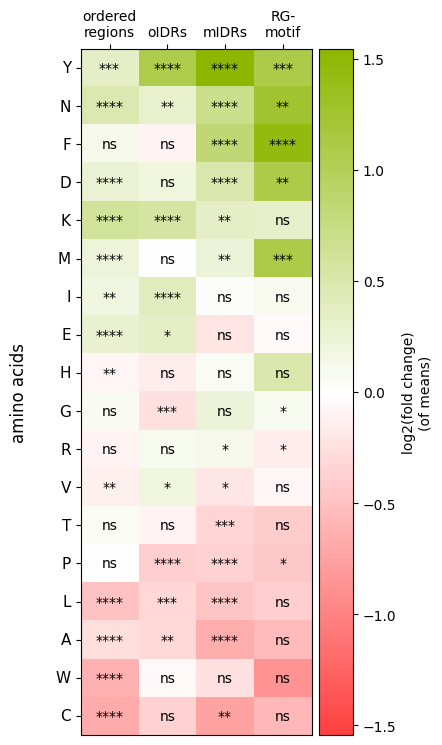

In [42]:
import math
print("missing are: I, H, M, T, Q ,S")
#['K', 'Y', 'N', 'D', 'E',  'F',  'P', 'V', 'W', 'A', 'C','L']


def create_heatmap(data, metrics_to_portray, aa_to_portray = list(), change_label_dict_y = dict(),
                   change_label_dict_x = dict(),vmax = None, cut_ns=True,sort_map=True, cell_size=10, output_data= False):
    # Create an empty array to store the p-values
    if len(aa_to_portray) == 0:
        for ki, vi in data.items():
            all_aa = list(data[ki].keys())
            break
    else:
        all_aa = aa_to_portray
    num_rows = len(all_aa) #list(data[list(data.keys())[0]].keys())
    num_cols = len(metrics_to_portray)

    # print(num_cols)
    # print(num_rows)

    custom_xticks = metrics_to_portray
    custom_yticks = all_aa
    # fold_changes = np.zeros((num_rows, num_cols), dtype=np.float)
    # labels = [[""] * num_cols for _ in range(num_rows)]  # Create an empty labels array

    # Extract the p-values and labels from the data and store them in the arrays
    # all_fold_changes = []
    fold_changes = []
    sign_labels = []
    num_labels = []
    for j,aa in enumerate(custom_yticks):
        fold_changes_as_list_temp, labels_as_list_temp, num_labels_temp = [], [], []
        for i,met  in enumerate(custom_xticks):
            # print(aa)
            # print(met)
            # print(data[met][aa][2])
            # print(data[met][aa][3])

            if data[met][aa][1] == 0 and data[met][aa][0] == 0:
                fold_change = np.log2(1)
            else:
                fold_change = np.log2(data[met][aa][0]/data[met][aa][1])
            # print(fold_change)
            # print("_____________________")
            # pvalasnum = data[met][aa][3]
            pvalasnum_fdrcorr = data[met][aa][4]

            fold_changes_as_list_temp.append(fold_change)
            labels_as_list_temp.append(pval_to_asterisk(pvalasnum_fdrcorr))
            num_labels_temp.append(pvalasnum_fdrcorr)

            # fold_changes[i, j] = fold_change
            # print(fold_changes)
            # all_fold_changes.append(fold_change)
            # labels[i][j] = pval_to_asterisk(pvalasnum_fdrcorr) #pvalasnum
        fold_changes.append(fold_changes_as_list_temp)
        sign_labels.append(labels_as_list_temp)
        num_labels.append(num_labels_temp)
    fold_changes = [[vmax if math.isinf(value) else value for value in sublist] for sublist in fold_changes]
    if cut_ns:
        fold_changes_temp, labels_as_list_temp, custom_yticks_temp, num_labels_temp = [], [], [], []
        for ind,xi in enumerate(sign_labels):
            if all(x == "ns" for x in xi):
                ##### here i could add something like a print out
                pass
            else:
                labels_as_list_temp.append(xi)
                fold_changes_temp.append(fold_changes[ind])
                custom_yticks_temp.append(custom_yticks[ind])
                num_labels_temp.append(num_labels[ind])
        fold_changes = fold_changes_temp
        custom_yticks = custom_yticks_temp
        sign_labels= labels_as_list_temp
        num_labels = num_labels_temp

    fold_changes=np.array([np.array(xi) for xi in fold_changes])
    # print(fold_changes)
    sign_labels=np.array([np.array(xi) for xi in sign_labels])
    num_cols= len(fold_changes[0])
    num_rows= len(fold_changes)
    if sort_map:
        indices = sorted(range(len(fold_changes)), key=lambda i: sum(fold_changes[i]), reverse=True)

        # Step 3: Use the indices to sort list_of_lists_non_numerical
        fold_changes = [fold_changes[i] for i in indices]
        sign_labels = [sign_labels[i] for i in indices]
        custom_yticks = [custom_yticks[i] for i in indices]
        num_labels =  [num_labels[i] for i in indices]

    # Normalize p-values to range from -1 to 1
    # all_fold_changes = np.array(all_fold_changes)
    # print(fold_changes)
    if vmax is None:
        vmax = np.nanmax(fold_changes)
        vmin = np.nanmin(fold_changes)
        print(vmax)
        print(vmin)
    # vmin = np.nanmin(fold_changes)
    # print(truemax)
    # print(vmin)
    # fold_changes_normalized = fold_changes / vmax
    # print(fold_changes)
    # fold_changes = [x if np.isfinite(x) else 0 for x in fold_changes]

    # Create a custom colormap with white at 0, green for positive, and red for negative values
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap',  [(0, '#FF4040'), ((0.5), 'white'), (1, '#8DB600')], N=256)
    # cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, '#FF4040'), (0.5, 'white'), (1, '#8DB600')], N=256)

    # Create the heatmap using the custom colormap
    fig = plt.figure(figsize=(num_cols*1.45*0.9,num_rows*0.55*0.9)) ## figsize=(num_cols*1.5, num_rows*1.5)
    # fig = plt.figure(figsize=(num_cols, num_rows))
    # print("test")
    
    plt.imshow(fold_changes, cmap=cmap, vmin=-vmax, vmax=vmax, extent=[0, num_cols, num_rows, 0], aspect=0.66)
    # print("test")
    # Calculate the exact center position for each cell
    x_positions = np.arange(num_cols) + 0.5
    y_positions = np.arange(num_rows) + 0.5

    # Show label text at the center of each cell
    for i, y in enumerate(y_positions):
        for j, x in enumerate(x_positions):
            plt.text(x, y, sign_labels[i][j], ha='center', va='center', fontsize=10, color='black')

    # plt.colorbar(shrink=0.5 ).set_label("enrichment")  # Add a colorbar to show the mapping of values to colors

    # Custom x-axis tick positions and labels
    # custom_xticks = np.arange(num_cols) + 1  # Add 1 to start the labels from 1
    # plt.xticks(x_positions, custom_xticks, rotation=45, ha='right')
    # custom_xticks_temp  = [-3,-2,-1,'motif', 1,2,3]
    # print(x_positions)
    plt.xticks(x_positions, custom_xticks, rotation=0, ha='right')

    # Custom y-axis tick positions and labels
    # custom_yticks = np.arange(num_rows) + 1  # Add 1 to start the labels from 1
    plt.yticks(y_positions, custom_yticks, va='center', size=11)
        # Let the horizontal axes labeling appear on top.
    plt.gca().tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("left")
    ###### CHANGE YLABELS
    y_labels = [item.get_text() for item in plt.gca().get_yticklabels()]
    for k in change_label_dict_y:
        try:
            pos = y_labels.index(k)
            y_labels[pos] = change_label_dict_y[k]
        except:
            print("Label", k, "could not be found!")
    plt.gca().set_yticklabels(y_labels)

    ###### CHANGE XLABELS
    # x_labels = [item.get_text() for item in plt.gca().get_xticklabels()]
    # for k in change_label_dict_x:
    #     try:
    #         pos = x_labels.index(k)
    #         x_labels[pos] = change_label_dict_y[k]
    #     except:
    #         print("Label", k, "could not be found!")
    # plt.gca().set_xticklabels(x_labels)
        ###### CHANGE XLABELS
    x_labels = [item.get_text() for item in plt.gca().get_xticklabels()]
    # print(x_labels)
    # for k in change_label_dict_x:
    #     try:
    #         pos = x_labels.index(k)
    #         x_labels[pos] = change_label_dict_y[k]
    #     except:
    #         print("Label", k, "could not be found!")
    plt.gca().set_xticklabels([change_label_dict_x.get(xlabel, xlabel) for xlabel in x_labels])
    ##### Assembling the statistics data in the form of a DF for the output
    data_dict = {}
    for ind1,xi in enumerate(fold_changes):
        data_dict[custom_yticks[ind1]] = {}
        for ind2,xii in enumerate(xi):
            data_dict[custom_yticks[ind1]][custom_xticks[ind2]] = (xii, num_labels[ind1][ind2])
    data_df = pd.DataFrame.from_dict(data_dict, orient='index')
    # print(data_df)

    # Rotate the tick labels and set their alignment.
    plt.setp(plt.gca().get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")
    
        # Create a colorbar closer to the plot
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.02)  # Reduce padding to move closer
    # plt.colorbar(im, cax=cax)

    cbar = plt.colorbar(fraction=0.25, location='right', pad=0.001 * len(y_labels)).set_label("log2(fold change)\n(of means)")  # Add a colorbar to show the mapping of values to colors
    
    # cbar.ax.set_position([0.85, 0.1, 0.03, 0.8])
    # plt.gca().tick_params(length=0)
    # plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    plt.xlabel("")  # Replace "X Axis Label" with your desired x-axis label
    # ax.yaxis.set_label_position("right")
    plt.ylabel("amino acids",size = 12, labelpad=20)  # Replace "Y Axis Label" with your desired y-axis label
    # subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'
    # plt.savefig(subfolder +  "4_AA_heatmap.svg", transparent=True)
    # plt.tight_layout()
    # plt.gca().label_params(axis='y', pad=10)
    # plt.show()
    # plt.close()
    if output_data:
        return fig, data_df
    else:
        return fig


xlabel_dict = {"density_overall": "full\nprotein",
               "density_outside_IDR": "ordered\nregions",
               "density_in_other_IDRs": "oIDRs",
               "density_in_motif_IDR": "mIDRs",
               "density_in_motif": "RG-\nmotif"}




# this_fig, this_data = create_heatmap(statistics_dict, ["density_overall"],
#                         ['K', 'Y', 'N', 'D', 'E',  'F','R', 'G','S', 'H', "I", "M", "Q", "T",  'P', 'V', 'W', 'A', 'C','L'],
#                         change_label_dict_x = xlabel_dict, sort_map =True,cut_ns=True, output_data=True
#                )
# # print(this_data)
# # , "density_in_motif_IDR"
# # file_name = "GAR_heatmap_amino_acids_entire_prot.png"
# aa_list_quick = list(this_data.index)
# print(aa_list_quick)
this_fig, this_data = create_heatmap(statistics_dict, ["density_outside_IDR", "density_in_other_IDRs","density_in_motif_IDR", "density_in_motif"],
                        ['K', 'Y', 'N', 'D', 'E',  'F','R', 'G','S', 'H', "I", "M", "Q", "T",  'P', 'V', 'W', 'A', 'C','L'], change_label_dict_x = xlabel_dict, vmax=None, sort_map =True, output_data=True
               )
# with open(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/no_collagen/' + file_name + '.pkl', 'wb') as fp:
#     pickle.dump(this_data, fp)
#     print('file saved successfully!')
# # significant_data.to_parquet(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/PTM overview/boxplots_for_singular_PTMs/' + title + ".parquet", index=False)
# this_fig.savefig(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/no_collagen/' + file_name + ".png")
# this_fig

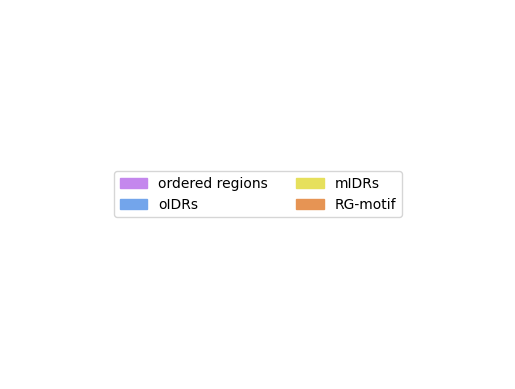

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Chosen colors and labels
colors = ['#C487ED', '#73A5EB', '#E6E05C', '#E69454']
labels = ['ordered regions', 'oIDRs', 'mIDRs', 'RG-motif']

# Create custom legend handles
handles = [Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Create a dummy figure for the legend
fig, ax = plt.subplots()
ax.axis('off')

# Add legend in a 2x2 layout
legend = ax.legend(handles=handles, ncol=1, loc='center', frameon=True)
subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

plt.savefig(subfolder +  "4_legend.svg", transparent=True)
plt.show()


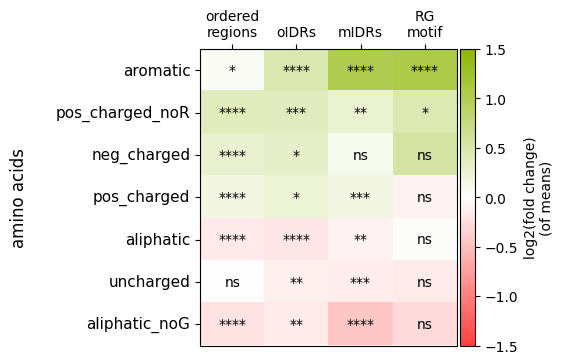

In [190]:
this_fig, this_data = create_heatmap(statistics_dict, ["density_outside_IDR", "density_in_other_IDRs", "density_in_motif_IDR", "density_in_motif"],
                        ['aromatic', 'aliphatic', 'pos_charged', 'neg_charged', 'uncharged', 'pos_charged_noR', 'aliphatic_noG'],change_label_dict_x = xlabel_dict,vmax=1.5, sort_map =True, output_data=True, cut_ns=False
               )
# file_name = "GAR_heatmap_aa_types_entire_prot.png"
# with open(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/no_collagen/' + file_name + '.pkl', 'wb') as fp:
#     pickle.dump(this_data, fp)
#     print('file saved successfully!')
# # significant_data.to_parquet(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/PTM overview/boxplots_for_singular_PTMs/' + title + ".parquet", index=False)
# this_fig.savefig(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/no_collagen/' + file_name + ".png", bbox_inches = 'tight')
# this_fig

{'counts_in_motif-11': '-11aa', 'counts_in_motif-10': '-10aa', 'counts_in_motif-9': '-9aa', 'counts_in_motif-8': '-8aa', 'counts_in_motif-7': '-7aa', 'counts_in_motif-6': '-6aa', 'counts_in_motif-5': '-5aa', 'counts_in_motif-4': '-4aa', 'counts_in_motif-3': '-3aa', 'counts_in_motif-2': '-2aa', 'counts_in_motif-1': '-1aa', 'density_in_motif': 'motif', 'counts_in_motif+1': '+1aa', 'counts_in_motif+2': '+2aa', 'counts_in_motif+3': '+3aa', 'counts_in_motif+4': '+4aa', 'counts_in_motif+5': '+5aa', 'counts_in_motif+6': '+6aa', 'counts_in_motif+7': '+7aa', 'counts_in_motif+8': '+8aa', 'counts_in_motif+9': '+9aa', 'counts_in_motif+10': '+10aa', 'counts_in_motif+11': '+11aa'}
4.186633460386126
0.6476100475128939


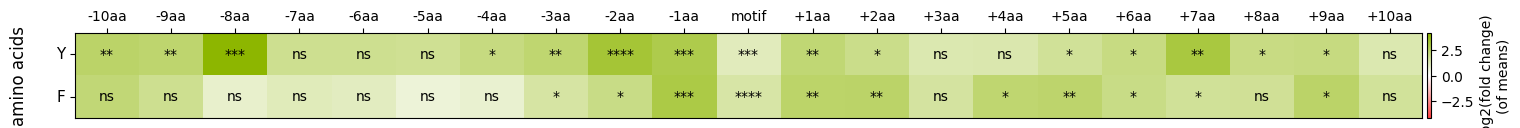

In [60]:
short_list = ['counts_in_motif']

one_step_list = [ #'counts_in_motif-25','counts_in_motif-24','counts_in_motif-23','counts_in_motif-22','counts_in_motif-21','counts_in_motif-20','counts_in_motif-19','counts_in_motif-18','counts_in_motif-17','counts_in_motif-16','counts_in_motif-15', 'counts_in_motif-14', 'counts_in_motif-13','counts_in_motif-12', 
    'counts_in_motif-11', 'counts_in_motif-10','counts_in_motif-9', 'counts_in_motif-8', 
    'counts_in_motif-7','counts_in_motif-6',
                                                        'counts_in_motif-5','counts_in_motif-4','counts_in_motif-3',
                                                        'counts_in_motif-2', 'counts_in_motif-1',
                                                        'density_in_motif',
                                                        'counts_in_motif+1', 'counts_in_motif+2', 'counts_in_motif+3',
                                                        'counts_in_motif+4','counts_in_motif+5',
                                                        'counts_in_motif+6','counts_in_motif+7',
                                                         'counts_in_motif+8', 'counts_in_motif+9', 'counts_in_motif+10', 'counts_in_motif+11'
                                                        #, 'counts_in_motif+12','counts_in_motif+13' ,'counts_in_motif+14', 'counts_in_motif+15', 'counts_in_motif+16', 'counts_in_motif+17', 'counts_in_motif+18', 'counts_in_motif+19', 'counts_in_motif+20', 'counts_in_motif+21', 'counts_in_motif+22', 'counts_in_motif+23', 'counts_in_motif+24', 'counts_in_motif+25'
                                                        ]
# one_step_list = [ #'counts_in_motif-25','counts_in_motif-24','counts_in_motif-23','counts_in_motif-22','counts_in_motif-21','counts_in_motif-20','counts_in_motif-19','counts_in_motif-18','counts_in_motif-17','counts_in_motif-16','counts_in_motif-15', 'counts_in_motif-14', 'counts_in_motif-13','counts_in_motif-12', 
#     # 'counts_in_motif-11', 'counts_in_motif-10','counts_in_motif-9', 'counts_in_motif-8', 
#     # 'counts_in_motif-7','counts_in_motif-6',
#                                                         'counts_in_motif-5','counts_in_motif-4','counts_in_motif-3',
#                                                         'counts_in_motif-2', 'counts_in_motif-1',
#                                                         'density_in_motif',
#                                                         'counts_in_motif+1', 'counts_in_motif+2', 'counts_in_motif+3',
#                                                         'counts_in_motif+4','counts_in_motif+5',
#                                                         # 'counts_in_motif+6','counts_in_motif+7',
#                                                         #  'counts_in_motif+8', 'counts_in_motif+9', 'counts_in_motif+10', 'counts_in_motif+11'
#                                                         #, 'counts_in_motif+12','counts_in_motif+13' ,'counts_in_motif+14', 'counts_in_motif+15', 'counts_in_motif+16', 'counts_in_motif+17', 'counts_in_motif+18', 'counts_in_motif+19', 'counts_in_motif+20', 'counts_in_motif+21', 'counts_in_motif+22', 'counts_in_motif+23', 'counts_in_motif+24', 'counts_in_motif+25'
#                                                         ]
xlabel_dict = {}
for el in one_step_list:
    if el == "density_in_motif":
        xlabel_dict[el] = "motif"
    else:
        xlabel_dict[el] = el.split("motif")[1] + "aa"
print(xlabel_dict)
final_step_list = [x for x in one_step_list if x in list(statistics_dict.keys())]

this_fig, this_data = create_heatmap(statistics_dict, final_step_list,
                        ["Y", "F"],change_label_dict_x = xlabel_dict, sort_map =True, vmax=None, output_data=True, cut_ns=True)
# 'K', 'Y', 'N', 'D', 'E',  'F','R', 'G','S', 'H', "I", "M", "Q", "T",  'P', 'V', 'W', 'A', 'C','L'
# , "A","N", "M", "D", "K", "T", "P", "L", "C"
# this_fig, this_data = create_heatmap(statistics_dict, final_step_list,
#                         ['aromatic', 'aliphatic', 'pos_charged', 'neg_charged', 'uncharged', 'pos_charged_noR', 'aliphatic_noG'],change_label_dict_x = xlabel_dict, sort_map =True, output_data=True, cut_ns=False)

# this_fig.gca().axvline(x=11, color='white', linestyle='-', linewidth=5)
# file_name = "GAR_full_heatmap_aa_positional_3aa_window"
# with open(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/no_collagen/' + file_name + '.pkl', 'wb') as fp:
#     pickle.dump(this_data, fp)
#     print('file saved successfully!')
# significant_data.to_parquet(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/PTM overview/boxplots_for_singular_PTMs/' + title + ".parquet", index=False)
# this_fig.savefig(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/no_collagen/' + file_name + ".png")
# this_fig

## ['Y', 'F', 'G', 'D', 'A']
#  ['A', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',  'S', 'T', 'V', 'W', 'Y', 'R', 'G']
# 'A', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',  'S', 'T', 'V', 'W', 'Y', 'R', 'G'

/tmp/ipykernel_15102/3091329539.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]


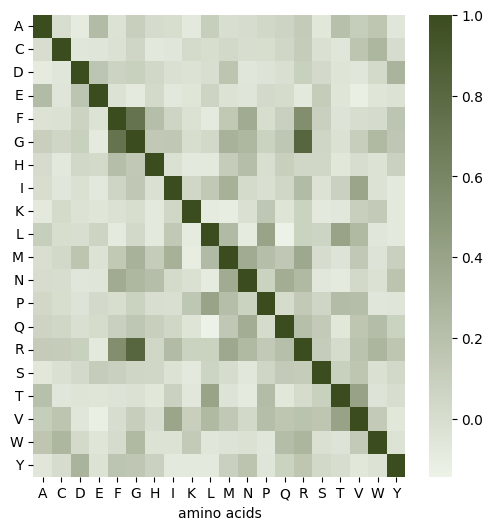

/tmp/ipykernel_15102/3091329539.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]


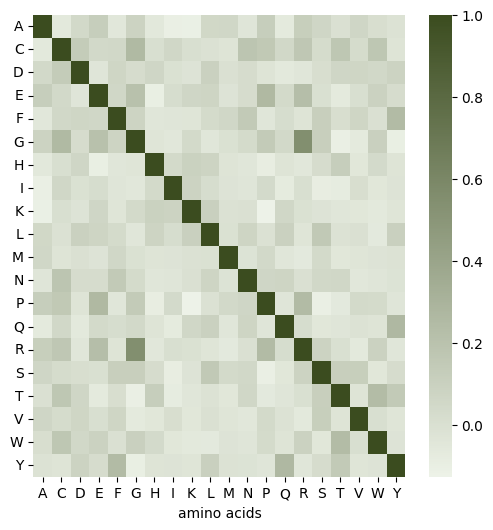

In [11]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
# print(cut_data)
# print(protein_df_with_aa_metrics_cleaned)
cut_data_pos = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "pos"]
# print(cut_data)
cut_data_neg = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "neg"]

def plot_corr_heat_map(data, all_aa):

    cut_data = data[data['aa'] .isin(all_aa)]
    mode = cut_data["Group"].unique()[0]
    # cut_data = cut_data[cut_data['aa'] .isin(["R", "G", "Y", "F", "W"])]
    # chosen_metrics = ten_step_list

    cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]

    # 'density_overall', 'density_outside_IDR', 'density_in_all_IDRs', 'density_in_motif_IDR'
    condition_2 = cut_data['metric'].isin(['counts_in_motif'])
    # condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-1", "Y_counts_in_motif+1","F_counts_in_motif+1", "Y_counts_in_motif+2", "Y_counts_in_motif-2", "F_counts_in_motif-1",])
    # condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-8", "Y_counts_in_motif-9","Y_counts_in_motif-10","Y_counts_in_motif-11","Y_counts_in_motif-6", "D_counts_in_motif-7", "D_counts_in_motif-6", "D_counts_in_motif-5","D_counts_in_motif-4","D_counts_in_motif-8",
    #                                                 "A_counts_in_motif-10", "A_counts_in_motif-9", "A_counts_in_motif-8","A_counts_in_motif-7","A_counts_in_motif-6","A_counts_in_motif-5",
    #                                                 "G_counts_in_motif+6", "G_counts_in_motif+7", "G_counts_in_motif+8","G_counts_in_motif+9"

    # ])

    # condition_4 = cut_data['merged_metric'].isin(["aromatic_counts_in_motif"])

    cut_data = cut_data[condition_2 ] # | condition_3

    # cut_data['merged_metric'] = cut_data['merged_metric'].str.replace('_counts_in_motif', '', regex=True)
    # print(cut_data)
    reshaped_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data')

    def sort_key(col):
        prefix, suffix = col.split('_', 1)  # Split at the first underscore
        splitval = suffix.split('motif')[1]
        if splitval == "":
            return prefix, 0
        else:
            return prefix, int(splitval)
    cols_sorted = sorted(reshaped_matrix.columns, key=sort_key)
    # Reorder the DataFrame columns based on the sorted index
    reshaped_matrix = reshaped_matrix[cols_sorted]
    # print(reshaped_matrix)
    correlation_matrix = reshaped_matrix.corr(method='pearson')
    # print(correlation_matrix)
    # correlation_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data').corr()
    # covar_matrix = cut_data.pivot_table(index='prot', columns='metric', values='data').cov()
    plt.figure(figsize=(6,6))

    # # Define a custom colormap
    # colors = ["lightgrey", "lightgrey", "darkred", "red", "red"]
    # cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    # Create a colormap with gray for values below 0.5, and 'viridis' for values above
    # cmap = ListedColormap(["gray"] + sns.color_palette("viridis", as_cmap=True)(128))

    # # Define boundaries so values below 0.5 are gray, above 0.5 use 'viridis'
    # bounds = [0, 0.5] + list(np.linspace(0.5, 1, 128))
    # norm = BoundaryNorm(bounds, cmap.N) , cmap="inferno"
    # test = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
    test = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
    test = sns.light_palette("#3b4c1f", as_cmap=True)
    # test = sns.light_palette("steelblue", as_cmap=True)
    sns.heatmap(correlation_matrix, annot=False, cbar=True, cmap=test)

    plt.xticks(np.arange(0.5, len(all_aa), 1.0), ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], rotation=0)
    plt.yticks(np.arange(0.5, len(all_aa), 1.0), ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], rotation=0)

    plt.xlabel("amino acids")
    plt.ylabel("")
    # plt.yticks([])
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'
    plt.savefig(subfolder +  "supp_corr_matrix_" + mode + ".svg", transparent=True)
    plt.show()

plot_corr_heat_map(cut_data_pos, all_aa)
plot_corr_heat_map(cut_data_neg, all_aa)

/tmp/ipykernel_15102/523524011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]


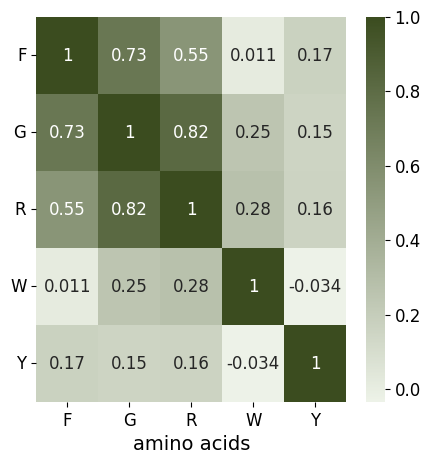

/tmp/ipykernel_15102/523524011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]


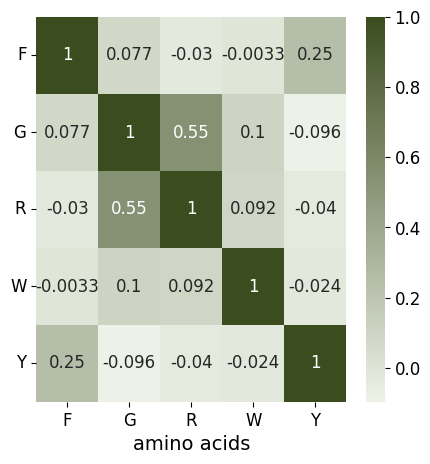

In [10]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
# print(cut_data)
# print(protein_df_with_aa_metrics_cleaned)
cut_data_pos = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "pos"]
# print(cut_data)
cut_data_neg = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "neg"]

def plot_corr_heat_map_detailed(cut_data, chosen_aa):

    cut_data = cut_data[cut_data['aa'] .isin(chosen_aa)]
    mode = cut_data["Group"].unique()[0]
    # cut_data = cut_data[cut_data['aa'] .isin(["R", "G", "Y", "F", "W"])]
    # chosen_metrics = ten_step_list

    cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]

    chosen_metrics = ['counts_in_motif'] # 'density_overall', 'density_outside_IDR', 'density_in_all_IDRs', 'density_in_motif_IDR'
    condition_2 = cut_data['metric'].isin(chosen_metrics)
    # condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-1", "Y_counts_in_motif+1","F_counts_in_motif+1", "Y_counts_in_motif+2", "Y_counts_in_motif-2", "F_counts_in_motif-1",])
    # condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-8", "Y_counts_in_motif-9","Y_counts_in_motif-10","Y_counts_in_motif-11","Y_counts_in_motif-6", "D_counts_in_motif-7", "D_counts_in_motif-6", "D_counts_in_motif-5","D_counts_in_motif-4","D_counts_in_motif-8",
    #                                                 "A_counts_in_motif-10", "A_counts_in_motif-9", "A_counts_in_motif-8","A_counts_in_motif-7","A_counts_in_motif-6","A_counts_in_motif-5",
    #                                                 "G_counts_in_motif+6", "G_counts_in_motif+7", "G_counts_in_motif+8","G_counts_in_motif+9"

    # ])

    # condition_4 = cut_data['merged_metric'].isin(["aromatic_counts_in_motif"])

    cut_data = cut_data[condition_2 ] # | condition_3

    # cut_data['merged_metric'] = cut_data['merged_metric'].str.replace('_counts_in_motif', '', regex=True)
    # print(cut_data)
    reshaped_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data')

    def sort_key(col):
        prefix, suffix = col.split('_', 1)  # Split at the first underscore
        splitval = suffix.split('motif')[1]
        if splitval == "":
            return prefix, 0
        else:
            return prefix, int(splitval)
    cols_sorted = sorted(reshaped_matrix.columns, key=sort_key)
    # Reorder the DataFrame columns based on the sorted index
    reshaped_matrix = reshaped_matrix[cols_sorted]
    # print(reshaped_matrix)
    correlation_matrix = reshaped_matrix.corr(method='pearson')
    # print(correlation_matrix)
    # correlation_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data').corr()
    # covar_matrix = cut_data.pivot_table(index='prot', columns='metric', values='data').cov()
    plt.figure(figsize=(5,5))

    # # Define a custom colormap
    # colors = ["lightgrey", "lightgrey", "darkred", "red", "red"]
    # cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    # Create a colormap with gray for values below 0.5, and 'viridis' for values above
    # cmap = ListedColormap(["gray"] + sns.color_palette("viridis", as_cmap=True)(128))

    # # Define boundaries so values below 0.5 are gray, above 0.5 use 'viridis'
    # bounds = [0, 0.5] + list(np.linspace(0.5, 1, 128))
    # norm = BoundaryNorm(bounds, cmap.N) , cmap="inferno"
    test = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)
    test = sns.light_palette("#3b4c1f", as_cmap=True)
    # test = sns.light_palette("steelblue", as_cmap=True)
    heatmap = sns.heatmap(correlation_matrix, annot=True, cbar=True, cmap=test, annot_kws={"fontsize": 12})
    colorbar = heatmap.collections[0].colorbar  # Get the colorbar object
    colorbar.ax.tick_params(labelsize=12)  
    plt.xticks(np.arange(0.5, len(list("FGRWY")), 1.0), list("FGRWY"), rotation=0, fontsize=12)
    plt.yticks(np.arange(0.5, len(list("FGRWY")), 1.0), list("FGRWY"), rotation=0, fontsize=12)

    plt.xlabel("amino acids", fontsize=14)
    plt.ylabel("")
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

    plt.savefig(subfolder +  "5_corr_matrix_" + mode + ".svg", transparent=True)
    # plt.yticks([])

    plt.show()

plot_corr_heat_map_detailed(cut_data_pos, list("FGRWY"))
plot_corr_heat_map_detailed(cut_data_neg, list("FGRWY"))

In [9]:
motif_info_set_df.Group.value_counts()

pos                287
neg                247
LLPS_pos_NA_neg    235
LLPS_neg_NA_pos     61
Name: Group, dtype: int64

In [10]:
import re

letter1 = 'Y'
letter2 = 'F'

window = 10

# used_motif_df = pd.read_parquet(r'/mnt/d/phd/scripts/3_mus_musculus/output/merged/annotated_sets/GAR_motif_Wang_set_merged_v3_annot.parquet')


group_used = "pos"
print(group_used)

used_motif_df = motif_info_set_df[motif_info_set_df["Group"] == group_used]

# count = used_motif_df["motif"].str.contains(letter1, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter1), axis=1).sum()
print(count)
# count = used_motif_df["motif"].str.contains(letter2, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter2), axis=1).sum()

print(count)
# count = used_motif_df["motif"].str.contains(f'(?=.*{letter1})(?=.*{letter2})', case=False, regex=True, na=False).sum()
count = used_motif_df.apply(
    lambda row: bool(re.search(f'(?=.*{letter1})(?=.*{letter2})', str(row["full_seq"][row["start"]-1:row["end"]]), re.IGNORECASE)), 
    axis=1
).sum()
print(count)

print("_____")
group_used = "neg"
print(group_used)
used_motif_df = motif_info_set_df[motif_info_set_df["Group"] == group_used]

# count = used_motif_df["motif"].str.contains(letter1, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter1), axis=1).sum()
print(count)
# count = used_motif_df["motif"].str.contains(letter2, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter2), axis=1).sum()

print(count)
# count = used_motif_df["motif"].str.contains(f'(?=.*{letter1})(?=.*{letter2})', case=False, regex=True, na=False).sum()
count = used_motif_df.apply(
    lambda row: bool(re.search(f'(?=.*{letter1})(?=.*{letter2})', str(row["full_seq"][row["start"]-1:row["end"]]), re.IGNORECASE)), 
    axis=1
).sum()
print(count)

print("_____")

group_used = "LLPS_pos_NA_neg"
print(group_used)
used_motif_df = motif_info_set_df[motif_info_set_df["Group"] == group_used]

# count = used_motif_df["motif"].str.contains(letter1, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter1), axis=1).sum()
print(count)
# count = used_motif_df["motif"].str.contains(letter2, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter2), axis=1).sum()

print(count)
# count = used_motif_df["motif"].str.contains(f'(?=.*{letter1})(?=.*{letter2})', case=False, regex=True, na=False).sum()
count = used_motif_df.apply(
    lambda row: bool(re.search(f'(?=.*{letter1})(?=.*{letter2})', str(row["full_seq"][row["start"]-1:row["end"]]), re.IGNORECASE)), 
    axis=1
).sum()
print(count)

print("_____")
group_used = "LLPS_neg_NA_pos"
print(group_used)
used_motif_df = motif_info_set_df[motif_info_set_df["Group"] == group_used]

# count = used_motif_df["motif"].str.contains(letter1, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter1), axis=1).sum()
print(count)
# count = used_motif_df["motif"].str.contains(letter2, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter2), axis=1).sum()

print(count)
# count = used_motif_df["motif"].str.contains(f'(?=.*{letter1})(?=.*{letter2})', case=False, regex=True, na=False).sum()
count = used_motif_df.apply(
    lambda row: bool(re.search(f'(?=.*{letter1})(?=.*{letter2})', str(row["full_seq"][row["start"]-1:row["end"]]), re.IGNORECASE)), 
    axis=1
).sum()
print(count)

print("_____")
group_used = ["pos", "neg", "LLPS_pos_NA_neg", "LLPS_neg_NA_pos"]
print(group_used)
used_motif_df = motif_info_set_df[motif_info_set_df["Group"].isin(group_used)]

# count = used_motif_df["motif"].str.contains(letter1, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter1), axis=1).sum()
print(count)
# count = used_motif_df["motif"].str.contains(letter2, na=False).sum()
count = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1:row["end"]]).__contains__(letter2), axis=1).sum()

print(count)
# count = used_motif_df["motif"].str.contains(f'(?=.*{letter1})(?=.*{letter2})', case=False, regex=True, na=False).sum()
count = used_motif_df.apply(
    lambda row: bool(re.search(f'(?=.*{letter1})(?=.*{letter2})', str(row["full_seq"][row["start"]-1:row["end"]]), re.IGNORECASE)), 
    axis=1
).sum()
print(count)

pos
25
56
11
_____
neg
3
7
1
_____
LLPS_pos_NA_neg
12
16
2
_____
LLPS_neg_NA_pos
0
8
0
_____
['pos', 'neg', 'LLPS_pos_NA_neg', 'LLPS_neg_NA_pos']
40
87
14


35
27
21
20
3


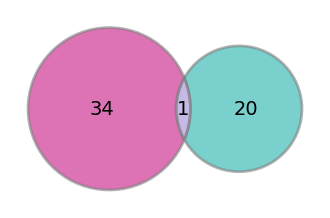

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd

# Define letters to search for
letter1 = 'Y'
letter2 = 'F'
threshold = 5
window = 30
# Filter dataframe for pos and neg groups
# group_used = ["pos", "neg"]
group_used = ["pos"] # , "pos", "LLPS_pos_NA_neg", "LLPS_neg_NA_pos"
# group_used = ["pos", "neg", "LLPS_pos_NA_neg", "LLPS_neg_NA_pos"]
used_motif_df = motif_info_set_df[motif_info_set_df["Group"].isin(group_used)]

# # Count occurrences
# count_A = used_motif_df["motif"].str.count(letter1).ge(threshold).sum()
# count_B = used_motif_df["motif"].str.count(letter2).ge(threshold).sum()
# count_AB = used_motif_df["motif"].apply(lambda x: (x.count(letter1) >= threshold) and (x.count(letter2) >= threshold)).sum()

# Count occurrences
# count_A = used_motif_df["motif"].str.count(letter1).ge(threshold).sum()
# count_B = used_motif_df["motif"].str.count(letter2).ge(threshold).sum()
# count_AB = used_motif_df["motif"].apply(lambda x: (x.count(letter1) >= threshold) and (x.count(letter2) >= threshold)).sum()

count_A = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1-window:row["end"]+window]).count(letter1) >= threshold, axis=1).sum()
proteins_A = used_motif_df.loc[
    used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1-window:row["end"]+window]).count(letter1) >= threshold, axis=1),
    "UniqueID"
].tolist()
print(len(proteins_A))
print(len(list(set(proteins_A))))
count_B = used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1-window:row["end"]+window]).count(letter2) >= threshold, axis=1).sum()
proteins_B = used_motif_df.loc[
    used_motif_df.apply(lambda row: str(row["full_seq"][row["start"]-1-window:row["end"]+window]).count(letter2) >= threshold, axis=1),
    "UniqueID"
].tolist()
print(len(proteins_B))
print(len(list(set(proteins_B))))

count_AB = used_motif_df.apply(lambda row: (str(row["full_seq"][row["start"]-1-window:row["end"]+window]).count(letter1) >= threshold) and 
                                           (str(row["full_seq"][row["start"]-1-window:row["end"]+window]).count(letter2) >= threshold), axis=1).sum()
proteins_AB = list(set(proteins_A) & set(proteins_B))
print(len(proteins_AB))

# count_AB = len(proteins_AB)

# Create Venn diagram
plt.figure(figsize=(4,4))
venn = venn2(subsets=(count_A - count_AB, count_B - count_AB, count_AB), 
             set_labels = ["", ""],
       set_colors = ("mediumvioletred", "lightseagreen"),alpha=0.6 )
# set_labels=(f"motifs with at least {threshold}\ntyrosine residues", f"motifs with at least {threshold}\nphenylalanine residues"),
for i in [0,1,2]:
    patch = venn.patches[i]
    if patch:
        patch.set_edgecolor('grey')
        patch.set_linestyle('solid')
        patch.set_linewidth(2)
for subset in venn.subset_labels:
    if subset:
        subset.set_fontsize(14)

# plt.title(f"Venn Diagram for '{letter1}' and '{letter2}' in Motifs with window of {window}")
subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'
plt.savefig(subfolder +  "5_Venn.svg", transparent=True)
plt.show()

output_dir = "/mnt/d/phd/scripts/3_mus_musculus/output_protein_lists_Y_F_20Mar25/"

# Save proteins_A
with open(output_dir + "output_protein_list_A.txt", "w") as f:
    f.write("\n".join(proteins_A))

# Save proteins_B
with open(output_dir + "output_protein_list_B.txt", "w") as f:
    f.write("\n".join(proteins_B))

# Save proteins_AB
with open(output_dir + "output_protein_list_AB.txt", "w") as f:
    f.write("\n".join(proteins_AB))

#### make it nicer

In [14]:
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mygene
import numpy as np
import time

def convert_uniprot_to_gene_symbols(uniprot_ids):
    """Converts a list of UniProt IDs to Entrez Gene Symbols using MyGene.info."""
    mg = mygene.MyGeneInfo()
    query_result = mg.querymany(uniprot_ids, scopes='uniprot', fields='symbol', species='human')
    
    symbol_counts = {}
    gene_symbols = []
    
    duplicates_checked = {}
    
    for entry in query_result:
        if "symbol" in entry:
            symbol = entry["symbol"]
            if symbol not in duplicates_checked:
                duplicates_checked[symbol] = []
            duplicates_checked[symbol].append(entry)
            
    for symbol, entries in duplicates_checked.items():
        unique_symbols = set(e["symbol"] for e in entries if "symbol" in e)
        if len(unique_symbols) == 1:
            gene_symbols.append(symbol)
        else:
            print(f"Potential ambiguous mapping for {symbol}: {unique_symbols}")
    
    return gene_symbols

def run_enrichment(protein_list, library="GO_Biological_Process_2021", max_retries=3):
    """Runs Enrichr enrichment analysis for a given protein list and GO library."""
    gene_symbols = convert_uniprot_to_gene_symbols(protein_list)
    
    for attempt in range(max_retries):
        try:
            enr = gp.enrichr(gene_list=gene_symbols, gene_sets=library, organism='human', outdir=None)
            if enr.results is None or enr.results.empty:
                print(f"No significant enrichment found for {library}.")
                return None
            return enr.results.sort_values(by="Adjusted P-value").head(10)  # Top 10 terms
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2)  # Wait before retrying
    
    print("Enrichr request failed after multiple attempts.")
    return None

def plot_enrichment(enrichment_results, title):
    """Plots enrichment results as a horizontal bar plot."""
    if enrichment_results is None:
        print(f"No significant enrichment found for {title}.")
        return
    
    enrichment_results["-log10(Adjusted P-value)"] = -enrichment_results["Adjusted P-value"].apply(lambda x: np.log10(x))
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=enrichment_results, 
        y="Term", 
        x="-log10(Adjusted P-value)", 
        palette="viridis"
    )
    plt.xlabel("-log10(Adjusted P-value)")
    plt.ylabel("GO Term")
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest enrichment at the top
    plt.tight_layout()
    plt.show()

# Example usage
protein_list1 = list(set([item for item in proteins_A if item not in proteins_AB])) # ["P04637", "P00533", "P38398", "P42345", "P06400"]  # UniProt IDs
protein_list2 = list(set([item for item in proteins_B if item not in proteins_AB]))# ["P01106", "P24941", "P11802", "P24385", "Q15796"]  # UniProt IDs

go_terms = ["GO_Biological_Process_2021", "GO_Molecular_Function_2021", "GO_Cellular_Component_2021"]
results_1 = []
results_2 = []
for go in go_terms:
    results_1.append(run_enrichment(protein_list1, go))
    results_2.append(run_enrichment(protein_list2, go))

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [ ]:
# Save to file
with open('QAD_listA.pkl', 'wb') as f:
    pickle.dump(results_1, f)

with open('QAD_listB.pkl', 'wb') as f:
    pickle.dump(results_2, f)



In [15]:
# Load from file
with open('QAD_listA.pkl', 'rb') as f:
    results_1 = pickle.load(f)

# Load from file
with open('QAD_listB.pkl', 'rb') as f:
    results_2 = pickle.load(f)


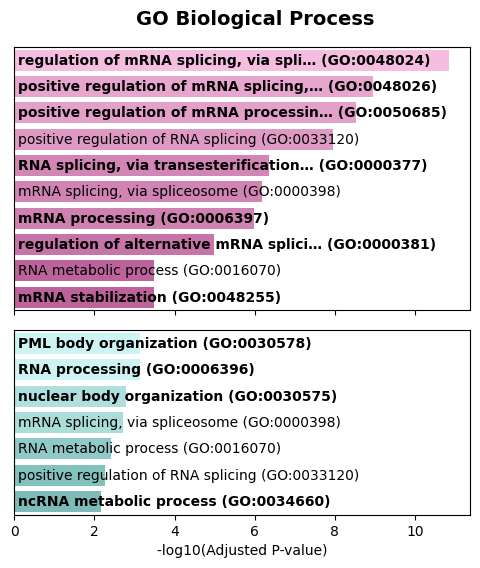

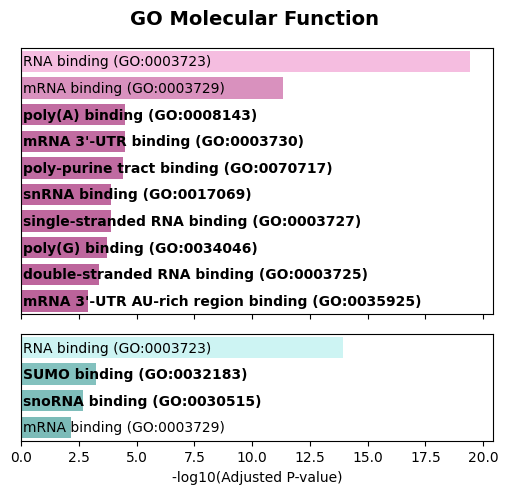

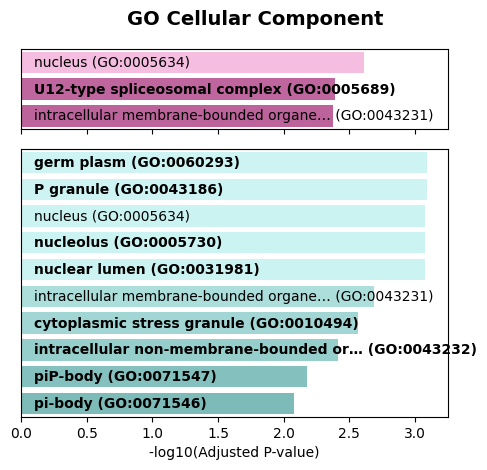

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def shorten_label(label, max_length=50):
    """Shortens labels while preserving the GO term in parentheses."""
    if len(label) <= max_length:
        return label
    if "(" in label and ")" in label:
        term = label[label.rfind("("):]  # Extract GO term in parentheses
        base = label[:max_length - len(term) - 1].rstrip()  # Truncate before GO term
        return f"{base}… {term}" if base else term  # Avoid empty base
    return label[:max_length - 1] + "…"  # Fallback truncation

def plot_enrichment(enrichment_results1, enrichment_results2, title):
    """Plots enrichment results as a horizontal bar plot with labels on top of the bars."""

    # Filter for significant terms (Adjusted P-value < 0.01)
    enrichment_results1 = enrichment_results1[enrichment_results1["Adjusted P-value"] < 0.01].copy()
    enrichment_results2 = enrichment_results2[enrichment_results2["Adjusted P-value"] < 0.01].copy()

    # If no terms remain after filtering, return
    if enrichment_results1.empty and enrichment_results2.empty:
        print(f"No significant enrichment found for {title}.")
        return

    enrichment_results1["-log10(Adjusted P-value)"] = -np.log10(enrichment_results1["Adjusted P-value"])
    enrichment_results2["-log10(Adjusted P-value)"] = -np.log10(enrichment_results2["Adjusted P-value"])

    num_terms1 = len(enrichment_results1)
    num_terms2 = len(enrichment_results2)
    
    # Height ratios to maintain equal bar widths
    height_ratios = [num_terms1, num_terms2] if num_terms1 and num_terms2 else [1, 1]

    fig, axs = plt.subplots(
        2, 1, sharex=True, figsize=(5.2, 1.5+ 0.25*(num_terms1 + num_terms2)), gridspec_kw={"height_ratios": height_ratios}
    )

    # Define custom colormap
    custom_colors_Y = ["#feb4e3", "#ca549e"]  # Light to dark pink shades
    custom_colors_F = ["#c6fbf9", "#71c6c2"]
    custom_cmap_Y = LinearSegmentedColormap.from_list("custom_rdpu", custom_colors_Y, N=256)
    custom_cmap_F = LinearSegmentedColormap.from_list("custom_rdpu", custom_colors_F, N=256)
    
    # Identify shared terms
    terms1 = set(enrichment_results1["Term"])
    terms2 = set(enrichment_results2["Term"])
    shared_terms = terms1 & terms2  # Terms appearing in both group
    for ax, enrichment_results, group_name in zip(
        axs, 
        [enrichment_results1, enrichment_results2], 
        ["tyrosine protein group", "phenylalanine protein group"]
    ):
        enrichment_results = enrichment_results.copy()
        enrichment_results["Short Term"] = enrichment_results["Term"].apply(shorten_label)

        # Normalize values for color mapping
        values = -enrichment_results["-log10(Adjusted P-value)"]
        norm_values = (values - values.min()) / (values.max() - values.min()) if len(values) > 1 else [0.5] * len(values)
        if group_name == "tyrosine protein group":
            colors = [custom_cmap_Y(val) for val in norm_values]
        else:
            colors = [custom_cmap_F(val) for val in norm_values]

        sns.barplot(
            data=enrichment_results, 
            y="Short Term", 
            x="-log10(Adjusted P-value)", 
            palette=colors, ax=ax
        )

        # Remove y-axis labels and ticks
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
        ax.set_xlabel("")
        
        # Ensure x-axis tick labels are visible
        # ax.tick_params(axis='x', labelbottom=True)

        # Set subplot title
        # ax.set_title(group_name, fontsize=12, fontweight="bold", rotation=90)
        
        # Add text labels on top of bars
        for bar, term, label in zip(ax.patches, enrichment_results["Term"], enrichment_results["Short Term"]):
            fontweight = "normal" if term in shared_terms else "bold"
            ax.text(
                0.1,  # Position at the end of the bar
                bar.get_y() + bar.get_height() / 2,  # Centered vertically
                label,
                ha="left", va="center", fontsize=10, fontweight=fontweight, color="black"
            )

    axs[-1].set_xlabel("-log10(Adjusted P-value)")
    plt.suptitle(title, fontsize=14, fontweight="bold")  # Main title
    plt.tight_layout()
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'
    plt.savefig(subfolder +  "5_" + title + ".svg", transparent=True)
    plt.show()



for i, go in enumerate(["GO Biological Process", "GO Molecular Function", "GO Cellular Component"]):
    plot_enrichment(results_1[i], results_2[i], f"{go}")


In [ ]:
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_enrichment(protein_list, library="GO_Biological_Process_2021"):
    """Runs Enrichr enrichment analysis for a given protein list and GO library."""
    enr = gp.enrichr(gene_list=protein_list, gene_sets=library, organism='human', outdir=None)
    if enr.results is None or enr.results.empty:
        return None
    return enr.results.sort_values(by="Adjusted P-value").head(10)  # Top 10 terms

def plot_enrichment(enrichment_results, title):
    """Plots enrichment results as a horizontal bar plot."""
    if enrichment_results is None:
        print(f"No significant enrichment found for {title}.")
        return
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=enrichment_results, 
        y="Term", 
        x="-log10(Adjusted P-value)", 
        palette="viridis"
    )
    plt.xlabel("-log10(Adjusted P-value)")
    plt.ylabel("GO Term")
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest enrichment at the top
    plt.tight_layout()
    plt.show()

# Example usage
protein_list1 = ["TP53", "EGFR", "BRCA1", "MTOR", "RB1"]  # Replace with your list
protein_list2 = ["MYC", "CDK2", "CDK4", "CCND1", "SMAD4"]  # Replace with your list

go_terms = ["GO_Biological_Process_2021", "GO_Molecular_Function_2021", "GO_Cellular_Component_2021"]
for go in go_terms:
    results1 = run_enrichment(protein_list1, go)
    results2 = run_enrichment(protein_list2, go)
    plot_enrichment(results1, f"{go} Enrichment - List 1")
    plot_enrichment(results2, f"{go} Enrichment - List 2")


ValueError: Could not interpret input '-log10(Adjusted P-value)'

<Figure size 800x500 with 0 Axes>

In [17]:
def find_all_occurrences(s, char , add=0):
    return [i+add for i, c in enumerate(s) if c == char]

def signed_distances_to_region_rel(positions, region, len=1):
    start, end = region
    distances = []
    for p in positions:
        # distances.append((p - ((start+end)/2))/len)
        if p < start:
            distances.append((p - start)/len)  # Negative for left side
        elif p > end:
            distances.append((p - end)/len)  # Positive for right side
        # else:
        #     distances.append(0)
    return distances

# chars_to_find = ["Y","N","F", "M", "D", "K", "A"]
chars_to_find = all_aa

pos_motif_df = motif_info_set_df[motif_info_set_df["Group"] == "pos"]
neg_motif_df = motif_info_set_df[motif_info_set_df["Group"] == "neg"]

pos_new_dict = {}
neg_new_dict = {}

all_pos_pre_seqs = []
all_pos_post_seqs = []
# all_neg_seqs = []
for ind,let in enumerate(chars_to_find):
    # print(let)
    temp_pos_new_data = []
    for i,r in pos_motif_df.iterrows():
        motif_IDR_ranges = protein_dict_with_aa_metrics[r["UniqueID"]]["motif_IDR_range"]
        for rng in motif_IDR_ranges:
            if r["start"] > rng[0] and r["end"] < rng[1]:
                corr_rng = rng
                break
        # print(r["start"])
        # print(r["end"])
        # print(corr_rng)
        # print(r["full_seq"][corr_rng[0]:corr_rng[1]])
        all_pos_pre_seqs.append(r["full_seq"][corr_rng[0]:r["start"]])
        post_seq = r["full_seq"][r["start"]:corr_rng[1]]
        positions = find_all_occurrences(r["full_seq"][corr_rng[0]:corr_rng[1]], let, corr_rng[0])
        # positions = find_all_occurrences(r["full_seq"], let)
        # print(positions)
        distances = signed_distances_to_region_rel(positions, (r["start"], r["end"]))
        # print(distances)
        # print("_____")
        temp_pos_new_data.append(distances)
    pos_new_dict[let] = temp_pos_new_data

    temp_neg_new_data = []
    for i,r in neg_motif_df.iterrows():
        motif_IDR_ranges = protein_dict_with_aa_metrics[r["UniqueID"]]["motif_IDR_range"]
        for rng in motif_IDR_ranges:
            if r["start"] > rng[0] and r["end"] < rng[1]:
                corr_rng = rng
                break
        positions = find_all_occurrences(r["full_seq"][corr_rng[0]:corr_rng[1]], let,corr_rng[0])
        distances = signed_distances_to_region_rel(positions, (r["start"], r["end"])) # , len(r["full_seq"][corr_rng[0]:corr_rng[1]])
        temp_neg_new_data.append(distances)
    neg_new_dict[let] = temp_neg_new_data
        # print(temp_new_col_dist)
# neg_new_dict

In [18]:
all_pos_pre_seqs = []
all_pos_post_seqs = []
all_pos_motifs = []
all_pos_full_length = []

pos_motif_df = motif_info_set_df[motif_info_set_df["Group"] == "pos"]
neg_motif_df = motif_info_set_df[motif_info_set_df["Group"] == "neg"]

for i,r in pos_motif_df.iterrows():
    motif_IDR_ranges = protein_dict_with_aa_metrics[r["UniqueID"]]["motif_IDR_range"]
    for rng in motif_IDR_ranges:
        if r["start"] > rng[0] and r["end"] < rng[1]:
            corr_rng = rng
            break
    all_pos_pre_seqs.append(r["full_seq"][corr_rng[0]:r["start"]-1])
    all_pos_motifs.append(r["motif"])
    all_pos_post_seqs.append(r["full_seq"][r["end"]:corr_rng[1]])
    all_pos_full_length.append(r["full_seq"][corr_rng[0]:corr_rng[1]])

# print(all_pos_pre_seqs)
# print(all_pos_motifs)
# print(all_pos_post_seqs)
# print(all_pos_full_length)

all_neg_pre_seqs = []
all_neg_post_seqs = []
for i,r in neg_motif_df.iterrows():
    motif_IDR_ranges = protein_dict_with_aa_metrics[r["UniqueID"]]["motif_IDR_range"]
    for rng in motif_IDR_ranges:
        if r["start"] > rng[0] and r["end"] < rng[1]:
            corr_rng = rng
            break
    all_neg_pre_seqs.append(r["full_seq"][corr_rng[0]:r["start"]])
    all_neg_post_seqs.append(r["full_seq"][r["end"]+1:corr_rng[1]])

In [19]:
import numpy as np
from collections import Counter
from Bio import SeqIO

def extract_sequences_from_fasta(fasta_file):
    sequences = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        record_new = record.id.split("|")[1]
        sequences[record_new] = str(record.seq)
    return sequences

def filter_sequences(sequences, masks):
    filtered_sequences = {}
    for identifier, seq in sequences.items():
        if identifier in masks:
            mask = masks[identifier]
            if len(seq) == len(mask):
                filtered_seq = ''.join([residue for residue, flag in zip(seq, mask) if flag])
                filtered_sequences[identifier] = filtered_seq
    return filtered_sequences

# Example usage
# sequences = {
#     "protein1": "ACDEFGHIKLMNPQRSTVWY",
#     "protein2": "MCCNYYGNSCGYGSSYGCGYGSGYGCGYGSSYGCGYGSGYGCGYGSSYGCGYGSGYSCGY"
# }

sequences = extract_sequences_from_fasta('/mnt/d/phd/scripts/raw_data/proteomes/UP000005640_9606.fasta')

# for key, value in list(sequences.items())[:5]:
#     print(f"{key}: {value}")
# annotated_IDR_df
masks = annotated_IDR_df.set_index("protein_name")["prediction-disorder-mobidb_lite"].to_dict()
# for key, value in list(masks.items())[:5]:
#     print(f"{key}: {value}")

# masks = {
#     "protein1": [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
#     "protein2": [0] * len(sequences["protein2"])
# }

filtered = filter_sequences(sequences, masks)
# for key, value in list(filtered.items())[:5]:
#     print(f"{key}: {value}")
# print(filtered["P35637"])
# print(annotated_IDR_df[annotated_IDR_df["protein_name"] == "A5PLN9"]["prediction-disorder-mobidb_lite"].tolist()[0])
# # print(annotated_IDR_df[annotated_IDR_df["protein_name"] == "A5PLN9"]["prediction-disorder-mobidb_lite"].sum())

def compute_aa_proportions(sequences):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard amino acids
    proportions = {aa: [] for aa in amino_acids}
    
    for seq in sequences:
        # print(seq)
        # print("______")
        # print(sequences[seq])
        seq_len = len(sequences[seq])
        if seq_len == 0:
            continue
        counts = Counter(sequences[seq])
        # print(counts)
        for aa in amino_acids:
            proportions[aa].append(counts.get(aa, 0) / seq_len)
    
    avg_proportions = {aa: 100*np.mean(proportions[aa]) for aa in amino_acids}
    sem_proportions = {aa: 100*(np.std(proportions[aa], ddof=1) / np.sqrt(len(proportions[aa]))) for aa in amino_acids}
    
    return avg_proportions, sem_proportions

# Example usage
# sequences = ["ACDEFGHIK", "LMNPQRSTVWY", "AAACCCGGGTTT", "LKHFBBSBIUBSIUS", "LJKBSIUABIBIUBAIBASIUSOISJH", "AAAAALLOANAOINAAAAIN"]
avg, sem = compute_aa_proportions(filtered)
print("Average Proportions:", avg)
print(sum(avg.values()))
print("Standard Error:", sem)

Average Proportions: {'A': 7.825638477960513, 'C': 0.8155611802500712, 'D': 5.392998421304032, 'E': 9.205374295383864, 'F': 1.1417551507722445, 'G': 9.336052018390074, 'H': 2.177105400632875, 'I': 1.3197478492090389, 'K': 6.179132352049365, 'L': 4.850637493889176, 'M': 1.5490399799502488, 'N': 2.9748547237586496, 'P': 12.35235529261875, 'Q': 5.259928390130603, 'R': 6.92875280936677, 'S': 12.726368047679951, 'T': 5.462608660661776, 'V': 3.0502312303745778, 'W': 0.5394620593395538, 'Y': 0.9080434178237378}
99.99564725154586
Standard Error: {'A': 0.04930580983095271, 'C': 0.013808836570507486, 'D': 0.040073144461800096, 'E': 0.06423010620908716, 'F': 0.013858139443443432, 'G': 0.05864558429067407, 'H': 0.0244042701835724, 'I': 0.015238525839896707, 'K': 0.053707889269865736, 'L': 0.028749796646011436, 'M': 0.016806799503377202, 'N': 0.02811523075651142, 'P': 0.06722732636248369, 'Q': 0.03696233462064064, 'R': 0.047554570143974316, 'S': 0.06185462855536711, 'T': 0.03695620453531758, 'V': 0

/tmp/ipykernel_15102/173279191.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=9)


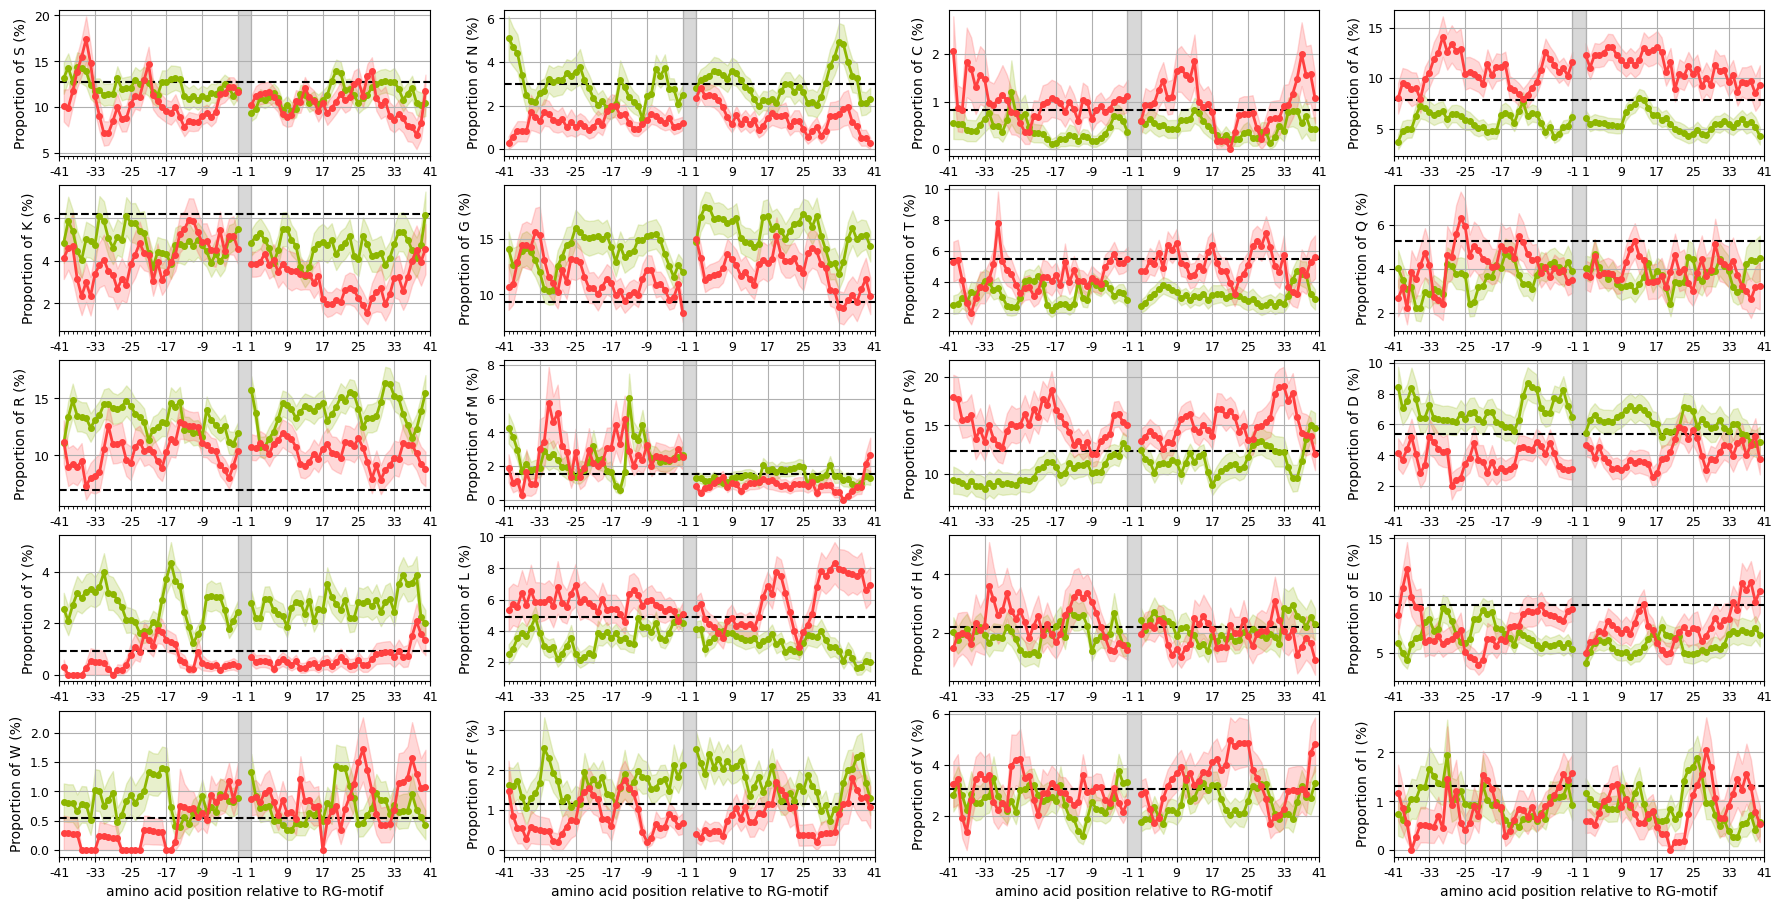

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

def calculate_aa_percentage(sequence, aa_list):
    """Computes the percentage of each amino acid in the given sequence."""
    counts = Counter(sequence)
    total = len(sequence) if sequence else 1  # Avoid division by zero
    return {aa: (counts[aa] / total) * 100 for aa in aa_list}

def compute_proportions(sequences, amino_acids, scope, window_size=1):
    """Computes amino acid proportions and standard error at each position."""
    aa_percentages = {aa: [] for aa in amino_acids}
    aa_stddev = {aa: [] for aa in amino_acids}
    aa_counts = {aa: [] for aa in amino_acids}

    for i in range(min(scope, 1), max(scope, -1) + 1):
        if scope > 0:
            merged_seqs = [lst[i-1:i+window_size] for lst in sequences if len(lst) > i+2]
        else:
            merged_seqs = [lst[i- 1 - window_size:i] for lst in sequences if len(lst) > abs(i)]

        merged_seqs_flat = list(chain.from_iterable(merged_seqs))
        proportions_list = [calculate_aa_percentage(seq, amino_acids) for seq in merged_seqs]

        avg_props = {aa: np.mean([p.get(aa, 0) for p in proportions_list]) for aa in amino_acids}
        stddevs = {aa: np.std([p.get(aa, 0) for p in proportions_list]) for aa in amino_acids}
        counts = {aa: max(1, len(proportions_list)) for aa in amino_acids}  # Avoid division by zero

        for aa in amino_acids:
            aa_percentages[aa].append(avg_props.get(aa, 0))
            aa_stddev[aa].append(stddevs[aa])
            aa_counts[aa].append(counts[aa])

    return aa_percentages, aa_stddev, aa_counts

def plot_aa_proportion(pre_pos, post_pos, pre_neg, post_neg, amino_acids, ref_props,ref_sems,  ylim_values=None, window_size = 1, scope=100, gap=1):
    """Plots amino acid proportions with shaded error regions for variability."""
    pre_pos_props, pre_pos_stddev, pre_pos_counts = compute_proportions(pre_pos, amino_acids, -scope, window_size)
    post_pos_props, post_pos_stddev, post_pos_counts = compute_proportions(post_pos, amino_acids, scope, window_size)
    pre_neg_props, pre_neg_stddev, pre_neg_counts = compute_proportions(pre_neg, amino_acids, -scope, window_size)
    post_neg_props, post_neg_stddev, post_neg_counts = compute_proportions(post_neg, amino_acids, scope,window_size)

    fig, axes = plt.subplots(len(amino_acids)//4, 4, figsize=(5.5*4, 1 +  2/4 * len(amino_acids)), sharex=False)
    axes = axes.flatten()
    i=0
    for ax, aa in zip(axes, amino_acids):
        i+=1
        # pre_x = np.array(range(-len(pre_pos_props[aa])-1, 0-1))
        # # print(pre_x)
        # post_x = np.array(range(1+2, len(post_pos_props[aa]) + 1 + 2))
        # print(post_x)
            # Example lengths (replace with your actual data)
        pre_pos_len = len(pre_pos_props[aa])  # Length of the pre-sequence
        post_pos_len = len(post_pos_props[aa])  # Length of the post-sequence

        # Create x-ticks for pre and post sequences with a gap of 5 ticks in between
        xticks_pre = np.arange(-pre_pos_len, 0)  # x-ticks for pre-sequence
        xticks_post = np.arange(1, post_pos_len + 1)  # x-ticks for post-sequence
        # gap = 1  # Set the width of the gap

        # Add the gap by offsetting post-sequence xticks
        xticks_post_offset = xticks_post + gap*1  # Offset the post-sequence ticks by 5

        # Compute SEM = standard deviation / sqrt(count)
        pre_pos_sem = np.array(pre_pos_stddev[aa]) / np.sqrt(np.array(pre_pos_counts[aa]))
        post_pos_sem = np.array(post_pos_stddev[aa]) / np.sqrt(np.array(post_pos_counts[aa]))
        pre_neg_sem = np.array(pre_neg_stddev[aa]) / np.sqrt(np.array(pre_neg_counts[aa]))
        post_neg_sem = np.array(post_neg_stddev[aa]) / np.sqrt(np.array(post_neg_counts[aa]))
        if aa in ref_props:
            ax.axhline(ref_props[aa], color="black", linestyle="dashed", label=f"Avg {aa} in Disordered Regions")
        # Plot shaded error regions for variation
        ax.fill_between(xticks_pre, np.array(pre_pos_props[aa]) - pre_pos_sem, np.array(pre_pos_props[aa]) + pre_pos_sem, color='#8DB600', alpha=0.2)
        ax.fill_between(xticks_post_offset, np.array(post_pos_props[aa]) - post_pos_sem, np.array(post_pos_props[aa]) + post_pos_sem, color='#8DB600', alpha=0.2)

        ax.fill_between(xticks_pre, np.array(pre_neg_props[aa]) - pre_neg_sem, np.array(pre_neg_props[aa]) + pre_neg_sem, color='#FF4040', alpha=0.2)
        ax.fill_between(xticks_post_offset, np.array(post_neg_props[aa]) - post_neg_sem, np.array(post_neg_props[aa]) + post_neg_sem, color='#FF4040', alpha=0.2)

        # Plot actual data with bold lines and small scatter points
        ax.plot(xticks_pre, pre_pos_props[aa], marker="o", markersize=4, linestyle="-", linewidth=2, color='#8DB600', label="Pre-Motif (Pos)")
        ax.plot(xticks_post_offset, post_pos_props[aa], marker="o", markersize=4, linestyle="-", linewidth=2, color='#8DB600')

        ax.plot(xticks_pre, pre_neg_props[aa], marker="o", markersize=4, linestyle="-", linewidth=2, color='#FF4040', label="Pre-Motif (Neg)")
        ax.plot(xticks_post_offset, post_neg_props[aa], marker="o", markersize=4, linestyle="-", linewidth=2, color='#FF4040')


            # ax.fill_between(range(xticks_pre[0],xticks_post_offset[-1]) , np.array(ref_props[aa]) - ref_sems[aa], np.array(ref_props[aa]) + ref_sems[aa], color='black', alpha=0.2)

        ax.set_ylabel(f"Proportion of {aa} (%)", size=10)
        ax.grid(True)



                # Custom x-ticks and labels

        ylims_now = ax.get_ylim()
        # print(ylims_now)
        ax.fill_between([-1,2], ylims_now[0]-5, ylims_now[1]+10, color="gray", alpha=0.3)
        ax.set_ylim(ylims_now)
        if ylim_values and aa in ylim_values:
            ax.set_ylim(ylim_values[aa])
        # Combine pre, gap, and post xticks
        # print(xticks_post_offset)
        xticks = np.concatenate([range(xticks_pre[-1], xticks_pre[0]-2, -int(scope/5)),range(xticks_post_offset[0], xticks_post_offset[-1]+2, int(scope/5))])
        xticks_minor = np.concatenate([range(xticks_pre[-1], xticks_pre[0]-2, -1),range(xticks_post_offset[0], xticks_post_offset[-1]+2, 1)])
        # print(xticks)
        # Create the corresponding labels
        xlabels = np.concatenate([range(xticks_pre[-1], xticks_pre[0]-2, -int(scope/5)),range(xticks_post_offset[0]-1, xticks_post_offset[-1]+1, int(scope/5))])  # Hide labels for the gap
        # xlabels = [str(x) if x != 0 else "" for x in xlabels]
        # print(xlabels)

        # Set xticks and labels
        ax.set_xticks(xticks)
        ax.set_xticks(xticks_minor, minor=True)
        ax.set_xticklabels(xlabels, size=9)
        ax.set_yticklabels(ax.get_yticklabels(), size=9)
        ax.set_xlim(-scope - 1, scope + gap + 1)
        # xticks = np.concatenate(range(-len(pre_pos_props[aa]), 0), [0] * 5, range(1, len(post_pos_props[aa]) + 1))  # Combine pre and post positions
        # xlabels = [str(x) if x != 0 else "" for x in xticks]  # Hide labels for the gap

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xlabels)
        if i > 16:
            ax.set_xlabel("amino acid position relative to RG-motif", size=10)
    subfolder= r'/mnt/d/phd/publications/1_RG_proteome_overview/subplots/'

    plt.savefig(subfolder + "supp_AA_distances.svg", transparent=True)
    # plt.tight_layout()
    plt.show()

# Example usage:
selected_aas = all_aa #["Y", "F"]  #["Y", "N", "F", "M", "D", "K", "R", "G", "P", "L", "A", "C", "W"]
# ref_y_props = {"S": 8.3, "P": 6.3, "E": 7.1, "K": 5.7, "G": 6.6, "Q": 4.8, "A": 7.0, "R": 5.6, "T": 5.4, "D": 4.7, "H": 2.6, "L": 10.0, "C": 2.3, "I": 4.3, "V": 6.0, "N": 3.6, "Y": 2.7, "F": 3.7, "M": 2.1, "W": 1.2}
ref_y_props = avg
ref_y_sem = sem
ylim_manual = {"A": (0, 25), "F": (0, 5), "R": (0, 25), "G": (0, 25)}

plot_aa_proportion(all_pos_pre_seqs, all_pos_post_seqs, all_neg_pre_seqs, all_neg_post_seqs, selected_aas, ref_y_props, ref_y_sem, ylim_values=None,  window_size= 4, scope=40)


In [166]:

# Example usage
long_string = "RKURGAGCTRGAGRGTCRGKRJGRLIKGRKJRGR"
char_to_find = "R"
region = (10, 17)  # Example region

positions = find_all_occurrences(long_string, char_to_find)
distances = signed_distances_to_region_rel(positions, region)
print(positions)
print(distances)  # List of signed distances


[0, 3, 9, 13, 17, 20, 23, 28, 31, 33]
[-10.0, -7.0, -1.0, 3.0, 6.0, 11.0, 14.0, 16.0]


In [ ]:
##### STARTING HERE UNUSED CODE NO CLEAN UP

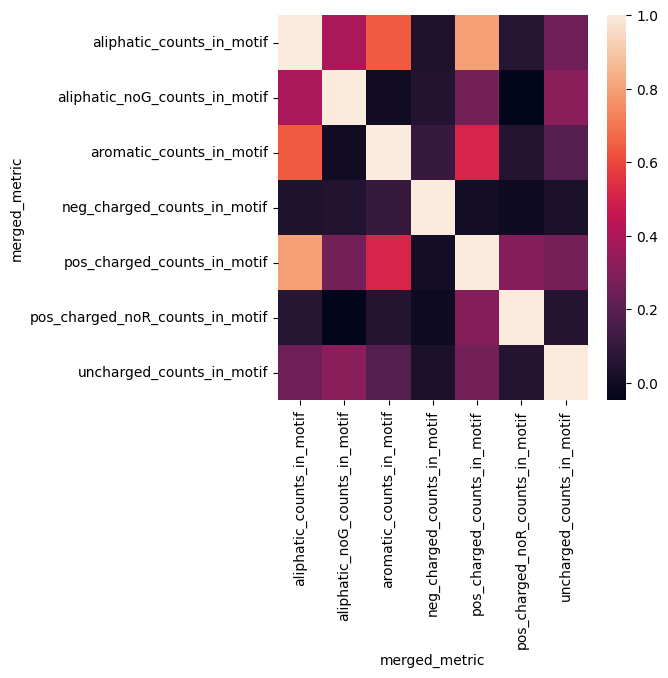

20 Lowest Correlations:
 merged_metric                    merged_metric                  
aliphatic_noG_counts_in_motif    pos_charged_noR_counts_in_motif   -0.047190
neg_charged_counts_in_motif      pos_charged_noR_counts_in_motif   -0.011458
aliphatic_noG_counts_in_motif    aromatic_counts_in_motif          -0.000825
neg_charged_counts_in_motif      pos_charged_counts_in_motif        0.002793
                                 uncharged_counts_in_motif          0.026701
aliphatic_counts_in_motif        neg_charged_counts_in_motif        0.035866
aliphatic_noG_counts_in_motif    neg_charged_counts_in_motif        0.050767
pos_charged_noR_counts_in_motif  uncharged_counts_in_motif          0.051294
aromatic_counts_in_motif         pos_charged_noR_counts_in_motif    0.053003
aliphatic_counts_in_motif        pos_charged_noR_counts_in_motif    0.061037
aromatic_counts_in_motif         neg_charged_counts_in_motif        0.107507
                                 uncharged_counts_in_motif     

In [79]:
from natsort import index_natsorted

one_step_list = [ #'counts_in_motif-25','counts_in_motif-24','counts_in_motif-23','counts_in_motif-22','counts_in_motif-21','counts_in_motif-20','counts_in_motif-19','counts_in_motif-18','counts_in_motif-17','counts_in_motif-16','counts_in_motif-15', 'counts_in_motif-14', 'counts_in_motif-13','counts_in_motif-12', 
    'counts_in_motif-11', 'counts_in_motif-10','counts_in_motif-9', 'counts_in_motif-8', 'counts_in_motif-7',
                                                        'counts_in_motif-6', 'counts_in_motif-5', 'counts_in_motif-4', 'counts_in_motif-3',
                                                        'counts_in_motif-2', 'counts_in_motif-1',
                                                        'counts_in_motif',
                                                        'counts_in_motif+1', 'counts_in_motif+2', 'counts_in_motif+3', 'counts_in_motif+4',
                                                        'counts_in_motif+5', 'counts_in_motif+6', 'counts_in_motif+7', 'counts_in_motif+8',
                                                        'counts_in_motif+9', 'counts_in_motif+10', 'counts_in_motif+11'
                                                        #, 'counts_in_motif+12','counts_in_motif+13' ,'counts_in_motif+14', 'counts_in_motif+15', 'counts_in_motif+16', 'counts_in_motif+17', 'counts_in_motif+18', 'counts_in_motif+19', 'counts_in_motif+20', 'counts_in_motif+21', 'counts_in_motif+22', 'counts_in_motif+23', 'counts_in_motif+24', 'counts_in_motif+25'
                                                        ]
short_one_step_list = [ #'counts_in_motif-25','counts_in_motif-24','counts_in_motif-23','counts_in_motif-22','counts_in_motif-21','counts_in_motif-20','counts_in_motif-19','counts_in_motif-18','counts_in_motif-17','counts_in_motif-16','counts_in_motif-15', 'counts_in_motif-14', 'counts_in_motif-13','counts_in_motif-12', 
    # 'counts_in_motif-3','counts_in_motif-2', 'counts_in_motif-1',
                                                        'counts_in_motif',
    # 'counts_in_motif+1', 'counts_in_motif+2', 'counts_in_motif+3'
                                                        #, 'counts_in_motif+12','counts_in_motif+13' ,'counts_in_motif+14', 'counts_in_motif+15', 'counts_in_motif+16', 'counts_in_motif+17', 'counts_in_motif+18', 'counts_in_motif+19', 'counts_in_motif+20', 'counts_in_motif+21', 'counts_in_motif+22', 'counts_in_motif+23', 'counts_in_motif+24', 'counts_in_motif+25'
                                                        ]
motif_list = [ #'counts_in_motif-25','counts_in_motif-24','counts_in_motif-23','counts_in_motif-22','counts_in_motif-21','counts_in_motif-20','counts_in_motif-19','counts_in_motif-18','counts_in_motif-17','counts_in_motif-16','counts_in_motif-15', 'counts_in_motif-14', 'counts_in_motif-13','counts_in_motif-12', 
                                                        'counts_in_motif'
                                                        #, 'counts_in_motif+12','counts_in_motif+13' ,'counts_in_motif+14', 'counts_in_motif+15', 'counts_in_motif+16', 'counts_in_motif+17', 'counts_in_motif+18', 'counts_in_motif+19', 'counts_in_motif+20', 'counts_in_motif+21', 'counts_in_motif+22', 'counts_in_motif+23', 'counts_in_motif+24', 'counts_in_motif+25'
                                                        ]

final_step_list = [x for x in short_one_step_list if x in list(statistics_dict.keys())]


cut_data = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "pos"]
cut_data = cut_data[cut_data['aa'] .isin(all_aa_types)] #all_aa_types + ["R", "G", "Y", "F", "W"]
# cut_data = cut_data[cut_data['aa'] .isin([ 'aromatic', 'neg_charged', 'uncharged', 'aliphatic_noG', 'pos_charged_noR', 'R', 'G', 'S'])] #all_aa_types + 
# cut_data = cut_data[cut_data['aa'] .isin(all_aa)]
chosen_metrics = final_step_list

cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]
# print(cut_data.merged_metric.unique())
# chosen_metrics = ['counts_in_motif'] # 'density_overall', 'density_outside_IDR', 'density_in_all_IDRs', 'density_in_motif_IDR'
condition_2 = cut_data['metric'].isin(chosen_metrics)
# condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-10", "Y_counts_in_motif+10", "Y_counts_in_motif+20"])
cut_data = cut_data[condition_2 ] # | condition_3

# cut_data


reshaped_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data')

# print(reshaped_matrix.columns)
sorted_index = index_natsorted(reshaped_matrix.columns)

# print("counts_in_motif".split('motif')[1])

def sort_key(col):
    prefix, suffix = col.split('_', 1)  # Split at the first underscore
    splitval = suffix.split('motif')[1]
    if splitval == "":
        return prefix, 0
    else:
        return prefix, int(splitval)
cols_sorted = sorted(reshaped_matrix.columns, key=sort_key)
# Reorder the DataFrame columns based on the sorted index
reshaped_matrix = reshaped_matrix[cols_sorted]
# print(reshaped_matrix)

# reshaped_matrix
correlation_matrix = reshaped_matrix.corr()
# print(correlation_matrix)
# covar_matrix = cut_data.pivot_table(index='prot', columns='metric', values='data').cov()
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=False)
# plt.xticks([])
# plt.yticks([])
plt.show()
# reshaped_matrix
# Mask to exclude self-correlation and NaNs
mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
# print(mask)
# Flatten the matrix and filter with the mask
corr_values = correlation_matrix.where(mask).stack()
# print(corr_values)
corr_values.columns = ['Row', 'Column', 'Correlation']
# print(type(corr_values))
# print(corr_values)
# Sort the correlation values
sorted_corr_values = corr_values.sort_values()

# Get the 10 lowest correlations
lowest_10 = sorted_corr_values.head(20)

# Get the 10 highest correlations
highest_10 = sorted_corr_values.tail(20)

print("20 Lowest Correlations:\n", lowest_10)
print("20 Highest Correlations:\n", highest_10)



           prot  motif aa           metric  data Group      merged_metric
28253    P0CJ87    625  F  counts_in_motif   0.0   pos  F_counts_in_motif
28314    P0CJ87    625  G  counts_in_motif   2.0   pos  G_counts_in_motif
28863    P0CJ87    625  R  counts_in_motif   2.0   pos  R_counts_in_motif
29107    P0CJ87    625  W  counts_in_motif   0.0   pos  W_counts_in_motif
29168    P0CJ87    625  Y  counts_in_motif   0.0   pos  Y_counts_in_motif
...         ...    ... ..              ...   ...   ...                ...
1354088  Q8N7U7   1430  F  counts_in_motif   0.0   pos  F_counts_in_motif
1354149  Q8N7U7   1430  G  counts_in_motif   3.0   pos  G_counts_in_motif
1354698  Q8N7U7   1430  R  counts_in_motif   2.0   pos  R_counts_in_motif
1354942  Q8N7U7   1430  W  counts_in_motif   0.0   pos  W_counts_in_motif
1355003  Q8N7U7   1430  Y  counts_in_motif   0.0   pos  Y_counts_in_motif

[1435 rows x 7 columns]
           prot  motif               aa               metric      data  \
0        Q5SS

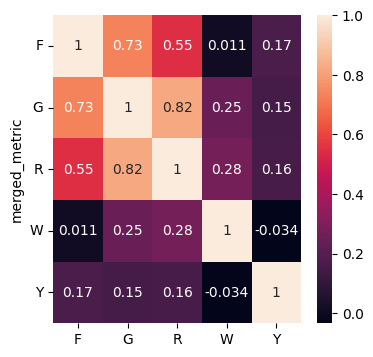

In [140]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
print(cut_data)
print(protein_df_with_aa_metrics_cleaned)
cut_data = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "pos"]
print(cut_data)
# cut_data = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "neg"]
cut_data = cut_data[cut_data['aa'] .isin(["R", "G", "Y", "F", "W"])]
# cut_data = cut_data[cut_data['aa'] .isin(["R", "G", "Y", "F", "W"])]
# chosen_metrics = ten_step_list

cut_data["merged_metric"] =  cut_data["aa"] + "_"  + cut_data["metric"]

chosen_metrics = ['counts_in_motif'] # 'density_overall', 'density_outside_IDR', 'density_in_all_IDRs', 'density_in_motif_IDR'
condition_2 = cut_data['metric'].isin(chosen_metrics)
# condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-1", "Y_counts_in_motif+1","F_counts_in_motif+1", "Y_counts_in_motif+2", "Y_counts_in_motif-2", "F_counts_in_motif-1",])
condition_3 = cut_data['merged_metric'].isin(["Y_counts_in_motif-8", "Y_counts_in_motif-9","Y_counts_in_motif-10","Y_counts_in_motif-11","Y_counts_in_motif-6", "D_counts_in_motif-7", "D_counts_in_motif-6", "D_counts_in_motif-5","D_counts_in_motif-4","D_counts_in_motif-8",
                                                "A_counts_in_motif-10", "A_counts_in_motif-9", "A_counts_in_motif-8","A_counts_in_motif-7","A_counts_in_motif-6","A_counts_in_motif-5",
                                                "G_counts_in_motif+6", "G_counts_in_motif+7", "G_counts_in_motif+8","G_counts_in_motif+9"

])

# condition_4 = cut_data['merged_metric'].isin(["aromatic_counts_in_motif"])

cut_data = cut_data[condition_2 ] # | condition_3

# cut_data['merged_metric'] = cut_data['merged_metric'].str.replace('_counts_in_motif', '', regex=True)
print(cut_data)
reshaped_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data')

def sort_key(col):
    prefix, suffix = col.split('_', 1)  # Split at the first underscore
    splitval = suffix.split('motif')[1]
    if splitval == "":
        return prefix, 0
    else:
        return prefix, int(splitval)
cols_sorted = sorted(reshaped_matrix.columns, key=sort_key)
# Reorder the DataFrame columns based on the sorted index
reshaped_matrix = reshaped_matrix[cols_sorted]
# print(reshaped_matrix)
correlation_matrix = reshaped_matrix.corr(method='pearson')
print(correlation_matrix)
# correlation_matrix = cut_data.pivot_table(index='prot', columns='merged_metric', values='data').corr()
# covar_matrix = cut_data.pivot_table(index='prot', columns='metric', values='data').cov()
plt.figure(figsize=(4,4))

# # Define a custom colormap
# colors = ["lightgrey", "lightgrey", "darkred", "red", "red"]
# cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Create a colormap with gray for values below 0.5, and 'viridis' for values above
# cmap = ListedColormap(["gray"] + sns.color_palette("viridis", as_cmap=True)(128))

# # Define boundaries so values below 0.5 are gray, above 0.5 use 'viridis'
# bounds = [0, 0.5] + list(np.linspace(0.5, 1, 128))
# norm = BoundaryNorm(bounds, cmap.N) , cmap="inferno"

sns.heatmap(correlation_matrix, annot=True, cbar=True)

plt.xticks(np.arange(0.5, len(["F", "G", "R", "W", "Y"]), 1.0), ["F", "G", "R", "W", "Y"], rotation=0)
plt.yticks(np.arange(0.5, len(["F", "G", "R", "W", "Y"]), 1.0), ["F", "G", "R", "W", "Y"], rotation=0)

plt.xlabel("")
# plt.yticks([])

plt.show()

In [96]:
cut_data

,prot,motif,aa,metric,data,Group,merged_metric
28009,P0CJ87,625,A,counts_in_motif,1.0,pos,A_counts_in_motif
28070,P0CJ87,625,C,counts_in_motif,0.0,pos,C_counts_in_motif
28131,P0CJ87,625,D,counts_in_motif,0.0,pos,D_counts_in_motif
28192,P0CJ87,625,E,counts_in_motif,0.0,pos,E_counts_in_motif
28253,P0CJ87,625,F,counts_in_motif,0.0,pos,F_counts_in_motif
...,...,...,...,...,...,...,...
1354759,Q8N7U7,1430,S,counts_in_motif,0.0,pos,S_counts_in_motif
1354820,Q8N7U7,1430,T,counts_in_motif,0.0,pos,T_counts_in_motif
1354881,Q8N7U7,1430,V,counts_in_motif,0.0,pos,V_counts_in_motif
1354942,Q8N7U7,1430,W,counts_in_motif,0.0,pos,W_counts_in_motif


In [ ]:
#### FROM HERE UNCLEAN AGAIN!!!!!

In [30]:
# protein_df_with_aa_metrics_cleaned
protein_df_with_aa_metrics_cleaned['Group'] = protein_df_with_aa_metrics_cleaned['prot'].apply(
                                                                    assign_groups_advanced,
                                                                     args= (  [x for x in set_list[set_names.index("GAR_NA_neg")] if x not in set_list[set_names.index("GAR_neg")]], "GAR_LLPS",
                                                                              [x for x in set_list[set_names.index("GAR_NA_pos")] if x not in set_list[set_names.index("GAR_pos")]], "GAR_NA",
                                                                              set_list[set_names.index("GAR_pos")], "all",
                                                                              set_list[set_names.index("GAR_neg")], "no"
                                                                                
                                                                            
                                                                             ))
### , 
                                                                                 # set_list[set_names.index("GAR_NA_neg")], "GAR_NA_neg",
                                                                                 # set_list[set_names.index("GAR_NA_pos")], "GAR_NA_pos"



protein_df_with_aa_metrics_FGcorr = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned["metric"].isin(["counts_in_motif"])]
protein_df_with_aa_metrics_FGcorr = protein_df_with_aa_metrics_FGcorr[protein_df_with_aa_metrics_FGcorr["aa"].isin(["R","G"])]
protein_df_with_aa_metrics_FGcorr[:15]

,prot,motif,aa,metric,data,Group
315,Q5SSQ6,608,G,counts_in_motif,3.0,no
864,Q5SSQ6,608,R,counts_in_motif,2.0,no
1962,Q7Z7L8,609,G,counts_in_motif,7.0,GAR_LLPS
2511,Q7Z7L8,609,R,counts_in_motif,6.0,GAR_LLPS
3609,Q8NAF0,610,G,counts_in_motif,11.0,GAR_NA
4158,Q8NAF0,610,R,counts_in_motif,10.0,GAR_NA
5256,Q9ULH4,611,G,counts_in_motif,4.0,no
5805,Q9ULH4,611,R,counts_in_motif,2.0,no
6903,Q8N878,612,G,counts_in_motif,2.0,no
7452,Q8N878,612,R,counts_in_motif,2.0,no


In [32]:
x_list, y_list = [], []
for i,r in protein_df_with_aa_metrics_FGcorr.iterrows():
    if r["aa"] == "R":
        x_list.append(r["data"])
    if r["aa"] == "G":
        y_list.append(r["data"])
x_list = [val for val in x_list for _ in (0, 1)]
print(x_list)        
print(len(x_list))    
y_list = [val for val in y_list for _ in (0, 1)] 
print(y_list)        
print(len(y_list))     
protein_df_with_aa_metrics_FGcorr['x'] = x_list
protein_df_with_aa_metrics_FGcorr['y'] = y_list
protein_df_with_aa_metrics_FGcorr = protein_df_with_aa_metrics_FGcorr[::2]
protein_df_with_aa_metrics_FGcorr

[2.0, 2.0, 6.0, 6.0, 10.0, 10.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 11.0, 11.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 3.0, 3.0, 2.0, 2.0, 4.0, 4.0, 5.0, 5.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 5.0, 5.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 14.0, 14.0, 11.0, 11.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 2.0, 2.0, 9.0, 9.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 2.0, 2.0, 2

,prot,motif,aa,metric,data,Group,x,y
315,Q5SSQ6,608,G,counts_in_motif,3.0,no,2.0,3.0
1962,Q7Z7L8,609,G,counts_in_motif,7.0,GAR_LLPS,6.0,7.0
3609,Q8NAF0,610,G,counts_in_motif,11.0,GAR_NA,10.0,11.0
5256,Q9ULH4,611,G,counts_in_motif,4.0,no,2.0,4.0
6903,Q8N878,612,G,counts_in_motif,2.0,no,2.0,2.0
...,...,...,...,...,...,...,...,...
1359090,Q53GS9,1433,G,counts_in_motif,3.0,GAR_LLPS,4.0,3.0
1360737,Q13470,1434,G,counts_in_motif,2.0,no,2.0,2.0
1362384,Q8N8E1,1435,G,counts_in_motif,2.0,no,2.0,2.0
1364031,Q8NG27,1436,G,counts_in_motif,2.0,GAR_LLPS,3.0,2.0


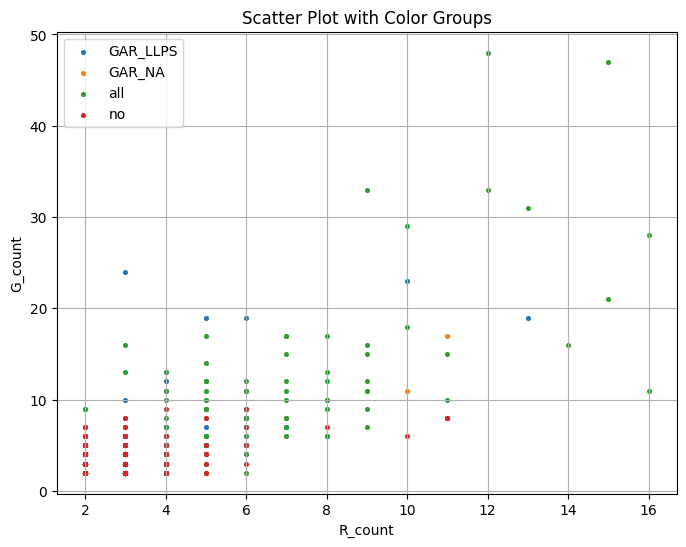

In [33]:
plt.figure(figsize=(8, 6))
for group, group_df in protein_df_with_aa_metrics_FGcorr.groupby('Group'):
    plt.scatter(group_df['x'], group_df['y'], label=group, s=7)

plt.xlabel('R_count')
plt.ylabel('G_count')
# plt.xlim(0,20)
# plt.ylim(0,100)
plt.title('Scatter Plot with Color Groups')
plt.legend()
plt.grid(True)
plt.show()

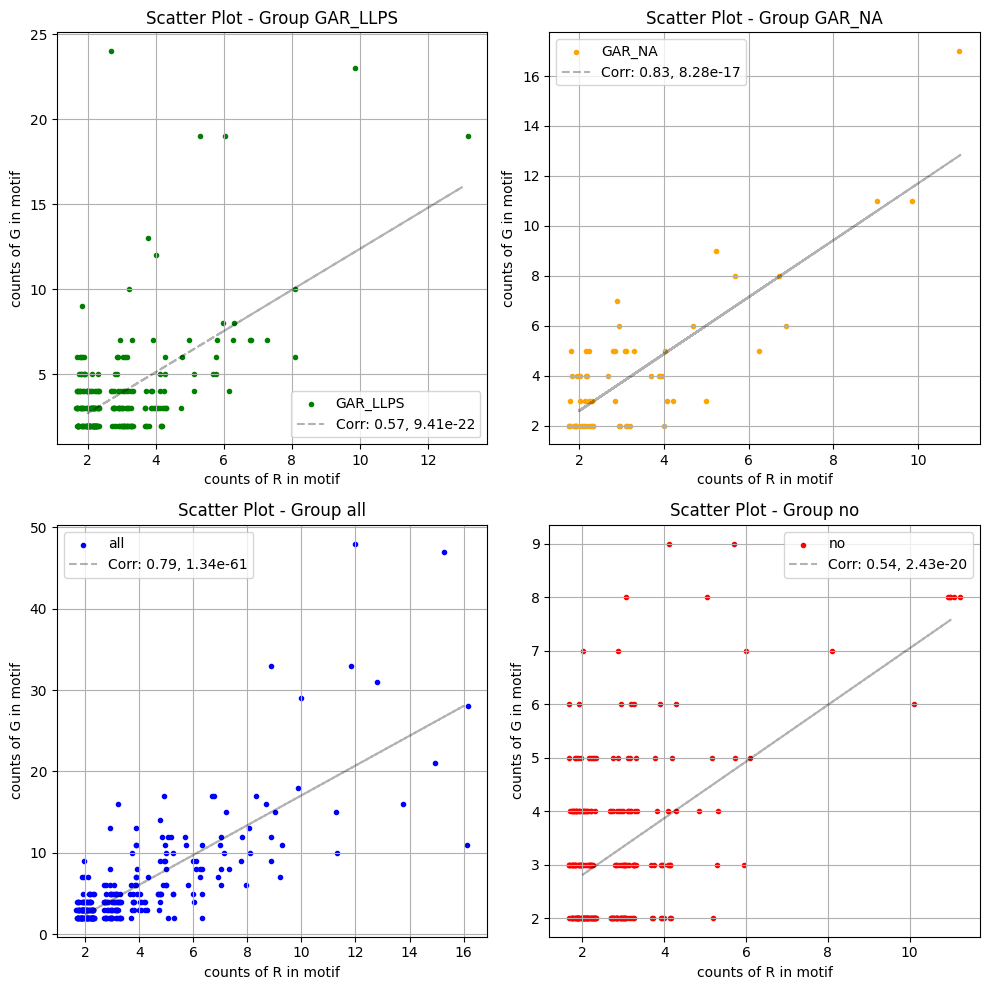

In [34]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
fig, axs = plt.subplots(2,2 , figsize=(10, 10))  # 2x2 grid for 4 groups
color_map = {'no': 'red', 'all': 'blue', 'GAR_LLPS': 'green', 'GAR_NA': 'orange'}
for i, (group, group_df) in enumerate(protein_df_with_aa_metrics_FGcorr.groupby('Group')):
    # group_df = group_df[(group_df['x'] != 0) & (group_df['y'] != 0)]

    ax = axs.flatten()[i]
    jitter = 0.33
    group_df['x_jittered'] = group_df['x'] + np.random.uniform(-jitter, jitter, size=len(group_df))
    ax.scatter(group_df['x_jittered'], group_df['y'], c=color_map[group], label=group, s=9)
    ax.set_xlabel('counts of R in motif')
    ax.set_ylabel('counts of G in motif')
    ax.set_title(f'Scatter Plot - Group {group}')
    ax.legend()
    ax.grid(True)
    
    corr, _ = pearsonr(group_df['x'], group_df['y'])
    m, b = np.polyfit(group_df['x'], group_df['y'], 1)
    ax.plot(group_df['x'], m * group_df['x'] + b, color='black', linestyle='--', alpha = 0.3, label=f'Corr: {corr:.2f}, {_:.2e}')
    ax.legend()
    # if i == 0:
    #     ax.set_xlim(0, 10)
    #     ax.set_ylim(0, 200)
    # ax.set_xscale('log')
    # ax.set_yscale('log')


plt.tight_layout()
plt.show()

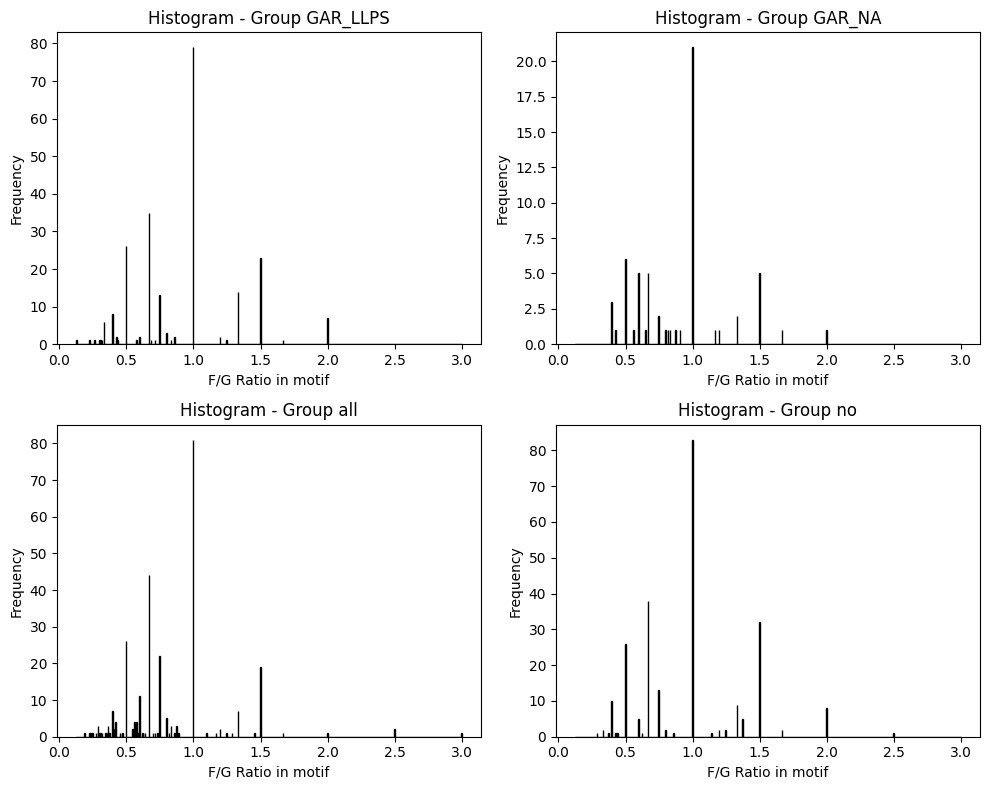

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid for 4 groups

protein_df_with_aa_metrics_FGcorr = protein_df_with_aa_metrics_FGcorr[(protein_df_with_aa_metrics_FGcorr['x'] != 0) & (protein_df_with_aa_metrics_FGcorr['y'] != 0)]
protein_df_with_aa_metrics_FGcorr['x_y_ratio'] = protein_df_with_aa_metrics_FGcorr['x'] / protein_df_with_aa_metrics_FGcorr['y']
bin_size = 0.005
bins = np.arange(protein_df_with_aa_metrics_FGcorr['x_y_ratio'].min(), protein_df_with_aa_metrics_FGcorr['x_y_ratio'].max() + bin_size, bin_size)

for ax, (group, group_df) in zip(axs.flatten(), protein_df_with_aa_metrics_FGcorr.groupby('Group')):
    
    
    ax.hist(group_df['x_y_ratio'], bins=bins, color='skyblue', edgecolor='black')
    ax.set_xlabel('F/G Ratio in motif')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram - Group {group}')
    # ax.set_xlim(0,0.3)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


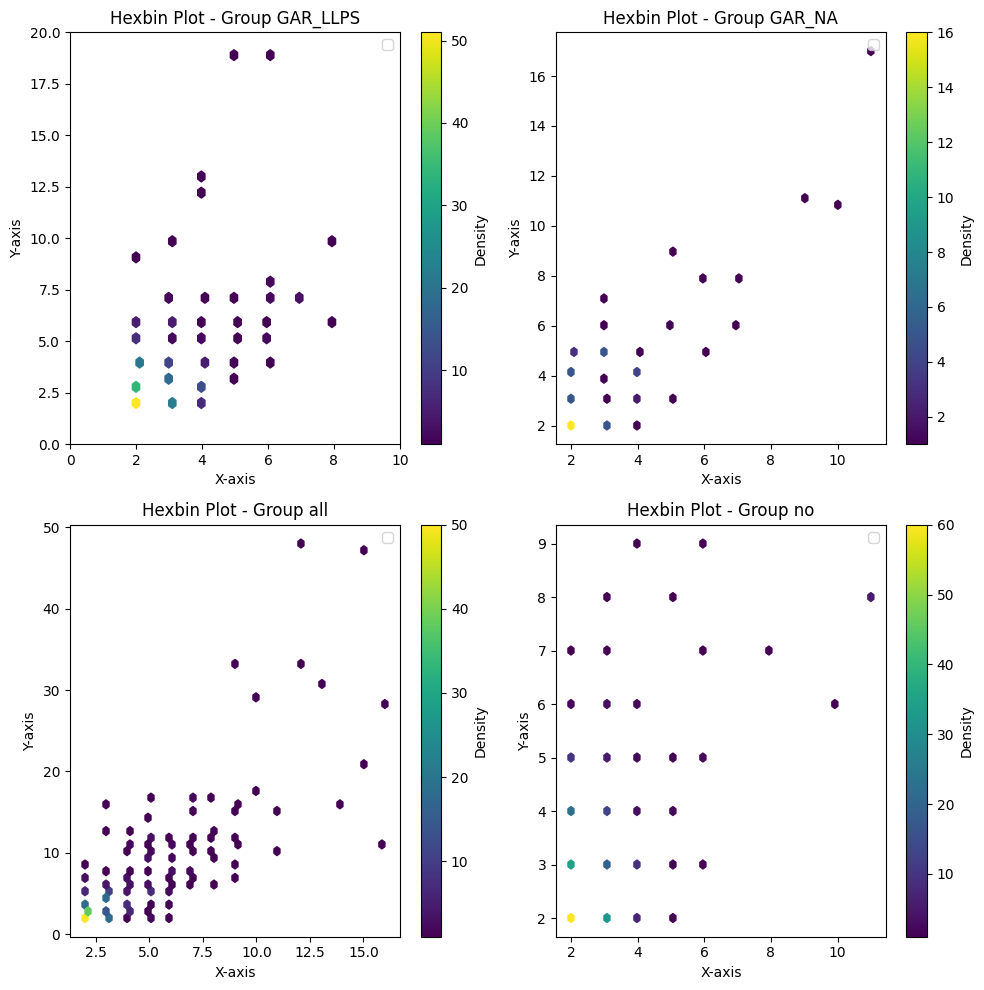

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid for 4 groups

for i, (group, group_df) in enumerate(protein_df_with_aa_metrics_FGcorr.groupby('Group')):
    ax = axs.flatten()[i]
    hb = ax.hexbin(group_df['x'], group_df['y'], gridsize=50, cmap='viridis', mincnt=1)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(f'Hexbin Plot - Group {group}')
    ax.legend()
    plt.colorbar(hb, ax=ax, label='Density')
    ax.grid(visible=False)
    if i == 0:
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()

/tmp/ipykernel_30168/1628408678.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(labels_pos)
/tmp/ipykernel_30168/1628408678.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(labels_neg)


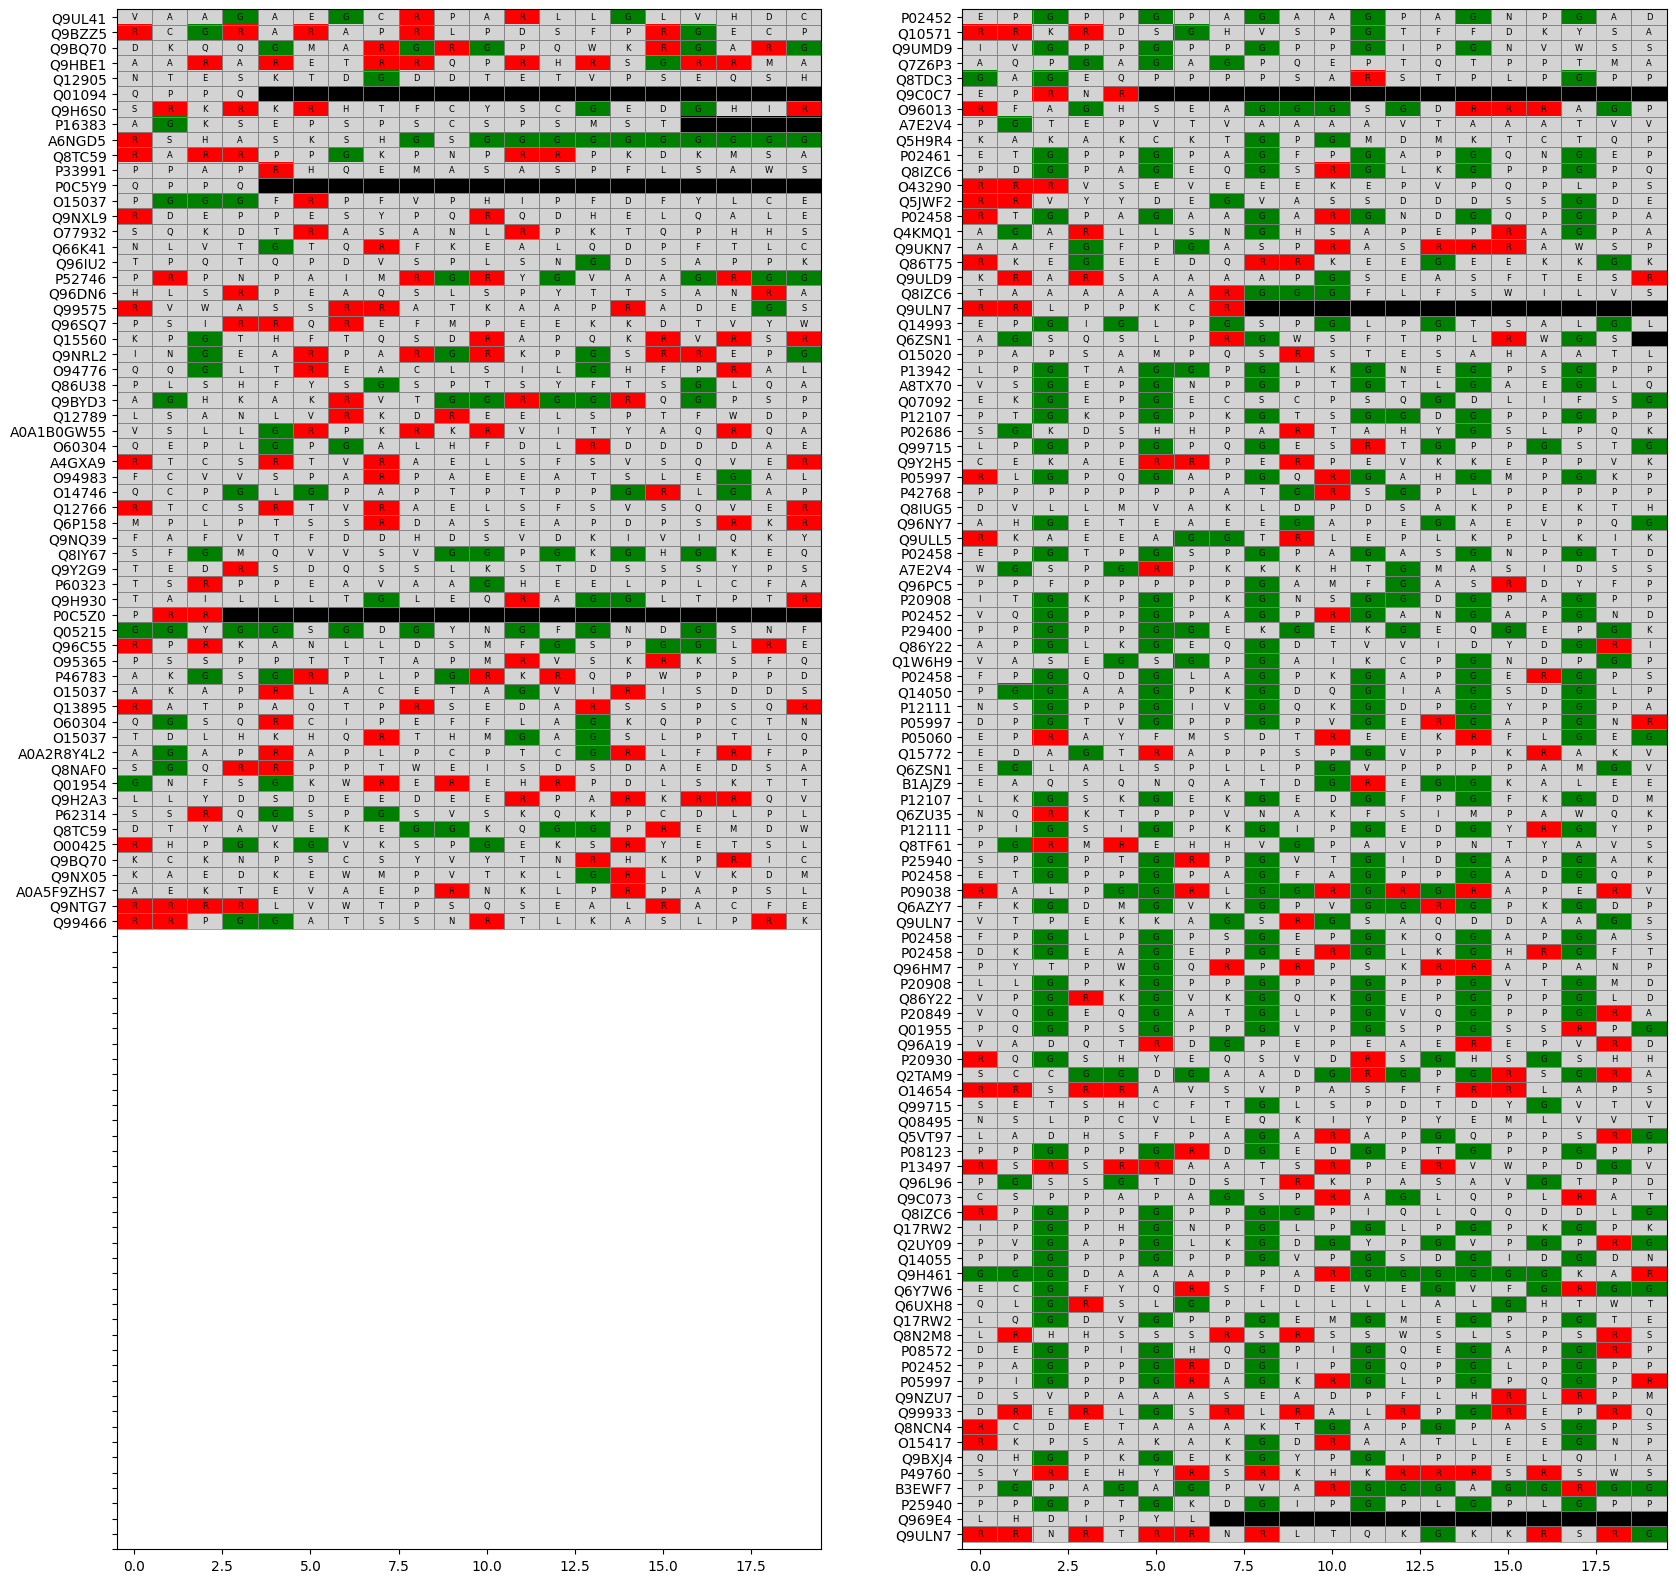

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import random
def custom_colormap(default_color='grey', color_dict=None):
    if color_dict is None:
        color_dict = {}

    colors = [default_color] * 26  # Default color for all values

    for let, color in color_dict.items():
        # print(let)
        # print(color)
        # print(letter_to_number(let))
        colors[letter_to_number(let)] = color
        # print(colors)

    return ListedColormap(colors)

def letter_to_number(letter):
    # Convert the letter to uppercase if needed
    letter = letter.upper()
    
    # Get the ASCII value of the letter and subtract the ASCII value of 'A' (65)
    return ord(letter) - 64 -1

def number_to_letter(number):
    # Convert the number to the respective letter (assuming A=1, B=2, ...)
    return chr(number + 64 + 1)  # A is 65 in ASCII



custom_colors = {'R': 'red', 'G': 'green', 'Z': 'black'}  # Numbers and their respective colors
cmap = custom_colormap(default_color='lightgrey', color_dict=custom_colors)



# new_df_test = protein_df_with_aa_metrics_cleaned[(protein_df_with_aa_metrics_cleaned['aa'] == "G") & (protein_df_with_aa_metrics_cleaned['metric'] == "counts_in_motif+3")]
all_neg_mots = list(protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "neg"]['motif'].unique())
all_pos_mots = list(protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['Group'] == "pos"]['motif'].unique())
# all_pos_mots

rand_100_mots_pos = random.sample(all_pos_mots, 60)
rand_100_mots_neg = random.sample(all_neg_mots, 100)


def pad_string(string):
    while len(string) < 20:
        string += "Z"
    return string[:20]

selected_rows_pos = motif_info_set_df.iloc[rand_100_mots_pos]
selected_rows_neg = motif_info_set_df.iloc[rand_100_mots_neg]
cut_up_seqs, labels_pos = [], []
for i,r in selected_rows_pos.iterrows():
    curr_seq = r['full_seq'][r['end']:r['end']+20]
    pad_curr_seq = pad_string(curr_seq)
    # curr_label = r['UniqueID']
    labels_pos.append(r['UniqueID'])
    cut_up_seqs.append(pad_curr_seq)
array_of_letters_pos = [np.array([char for char in el]) for el in cut_up_seqs]
sequences_neg = array_of_letters_pos


cut_up_seqs, labels_neg = [], []
for i,r in selected_rows_neg.iterrows():
    curr_seq = r['full_seq'][r['end']:r['end']+20]
    pad_curr_seq = pad_string(curr_seq)
    labels_neg.append(r['UniqueID'])
    cut_up_seqs.append(pad_curr_seq)
array_of_letters_neg = [np.array([char for char in el]) for el in cut_up_seqs]
sequences_neg = array_of_letters_neg

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
# print(labels_neg)
# print(cmap)

# Map amino acids to their respective group numbers
sequence_group_numbers = np.zeros((len(sequences_pos), len(sequences_pos[0])))
for i, seq in enumerate(sequences_pos):
    for j, aa in enumerate(seq):
        sequence_group_numbers[i, j] = letter_to_number(aa)
# print(sequence_group_numbers.shape)
axs[0].imshow(sequence_group_numbers,cmap=cmap, aspect='auto', vmin=0, vmax = 25)
# print(sequence_group_numbers)
# Add annotations with group numbers
for i in range(len(sequences_pos)):
    for j in range(len(sequences_pos[0])):
        axs[0].text(j, i, number_to_letter(int(sequence_group_numbers[i, j])), ha='center', va='center', color='black', size=6)
        axs[0].add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='grey', fill=False, linewidth=0.5))
axs[0].set_yticklabels(labels_pos)
axs[0].set_yticks(range(0, 101))



# Map amino acids to their respective group numbers
sequence_group_numbers = np.zeros((len(sequences_neg), len(sequences_neg[0])))
for i, seq in enumerate(sequences_neg):
    for j, aa in enumerate(seq):
        sequence_group_numbers[i, j] = letter_to_number(aa)

axs[1].imshow(sequence_group_numbers,cmap=cmap, aspect='auto', vmin=0, vmax = 25)
# print(sequence_group_numbers)
# Add annotations with group numbers
for i in range(len(sequences_neg)):
    for j in range(len(sequences_neg[0])):
        axs[1].text(j, i, number_to_letter(int(sequence_group_numbers[i, j])), ha='center', va='center', color='black', size=6)
        axs[1].add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='grey', fill=False, linewidth=0.5))
axs[1].set_yticklabels(labels_neg)
axs[1].set_yticks(range(0, 101))




plt.show()


In [275]:
motif_info_set_df[motif_info_set_df['UniqueID'] == 'Q07092']

,UniqueID,EntryName,motif,r_to_g_ratio,g_perc,r_perc,start,end,full_seq,Else,...,domain_distance,IDR_overlap,IDR_position,PTM_names,PTM_distance,PTM_players,PTM_type,cur_llps_type,llps_pred_score,llps_pred_rank
2065,Q07092,COGA1_HUMAN,GLRGTPGEKGPRG,0.400000,38.461538,15.384615,856,868,MWVSWAPGLWLLGLWATFGHGANTGAQCPPSQQEGLKLEHSSSLPA...,"{'A': None, 'C': None, 'D': None, 'E': 1.0, 'F...",...,[-625.0],yes,-0.654952,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-809, -529]","[[], []]","[CARBOHYD, CARBOHYD]",None,0.891934,0.690697
2066,Q07092,COGA1_HUMAN,GQRGEEGPPGMRG,0.400000,38.461538,15.384615,1030,1042,MWVSWAPGLWLLGLWATFGHGANTGAQCPPSQQEGLKLEHSSSLPA...,"{'A': None, 'C': None, 'D': None, 'E': 2.0, 'F...",...,[-799.0],yes,0.831776,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-983, -703]","[[], []]","[CARBOHYD, CARBOHYD]",None,0.891934,0.690697
2067,Q07092,COGA1_HUMAN,GPRGERG,0.666667,42.857143,28.571429,1135,1141,MWVSWAPGLWLLGLWATFGHGANTGAQCPPSQQEGLKLEHSSSLPA...,"{'A': None, 'C': None, 'D': None, 'E': 1.0, 'F...",...,[-904.0],yes,0.355140,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-1088, -808]","[[], []]","[CARBOHYD, CARBOHYD]",None,0.891934,0.690697
2068,Q07092,COGA1_HUMAN,GDRGATGERG,0.500000,40.000000,20.000000,1314,1323,MWVSWAPGLWLLGLWATFGHGANTGAQCPPSQQEGLKLEHSSSLPA...,"{'A': 1.0, 'C': None, 'D': 1.0, 'E': 1.0, 'F':...",...,[-1083.0],yes,-0.490654,"[N-linked (GlcNAc...) asparagine, N-linked (Gl...","[-1267, -987]","[[], []]","[CARBOHYD, CARBOHYD]",None,0.891934,0.690697


In [274]:
c_1 = protein_df_with_aa_metrics_cleaned["aa"] == "G"
c_2 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+3") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
c_3 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+6") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
c_4 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+9") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
# c_5 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+12") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
# c_6 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+15") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
# c_3 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+6") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
# c_3 = (protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+6") & (protein_df_with_aa_metrics_cleaned["data"] == 1)
# c_4 = protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif)+9" & protein_df_with_aa_metrics_cleaned["data"] == 1
# c_5 = protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+12" & protein_df_with_aa_metrics_cleaned["data"] == 1
# c_6 = protein_df_with_aa_metrics_cleaned["metric"] == "counts_in_motif+15" & protein_df_with_aa_metrics_cleaned["data"] == 1




new_set = protein_df_with_aa_metrics_cleaned[c_1 & (c_2 | c_3 |c_4 )] ##|c_5 |c_6

new_set["prot_motif"] = new_set['prot'] + "_" + new_set['motif'].astype(str)
# new_set[new_set['prot'] == 'P02458']
new_set_value_counts = new_set["prot_motif"].value_counts().to_dict()
new_set_value_counts



# Filter keys where the value is 4 or larger
keys_with_4_or_more = [key for key, value in new_set_value_counts.items() if value == 2]
keys_with_4_or_more = [e.split("_")[0] for e in keys_with_4_or_more]
keys_with_4_or_more = list(set(keys_with_4_or_more))
print(len(keys_with_4_or_more))
keys_with_4_or_more

20


/tmp/ipykernel_30168/3148280115.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_set["prot_motif"] = new_set['prot'] + "_" + new_set['motif'].astype(str)


['Q07092',
 'Q6UXH8',
 'Q7Z4V5',
 'Q02388',
 'Q9UMD9',
 'P09038',
 'Q9Y3Q4',
 'Q14050',
 'Q8NDL9',
 'P57796',
 'Q8N3D4',
 'P29400',
 'Q6RI45',
 'Q96PV6',
 'Q52LJ0',
 'Q86Y22',
 'Q9BXX0',
 'Q9NQS1',
 'O60293',
 'P12111']

[[('pos', 'counts_in_motif-40'), ('neg', 'counts_in_motif-40')], [('pos', 'counts_in_motif-30'), ('neg', 'counts_in_motif-30')], [('pos', 'counts_in_motif-20'), ('neg', 'counts_in_motif-20')], [('pos', 'counts_in_motif-10'), ('neg', 'counts_in_motif-10')], [('pos', 'counts_in_motif'), ('neg', 'counts_in_motif')], [('pos', 'counts_in_motif+10'), ('neg', 'counts_in_motif+10')], [('pos', 'counts_in_motif+20'), ('neg', 'counts_in_motif+20')], [('pos', 'counts_in_motif+30'), ('neg', 'counts_in_motif+30')], [('pos', 'counts_in_motif+40'), ('neg', 'counts_in_motif+40')]]


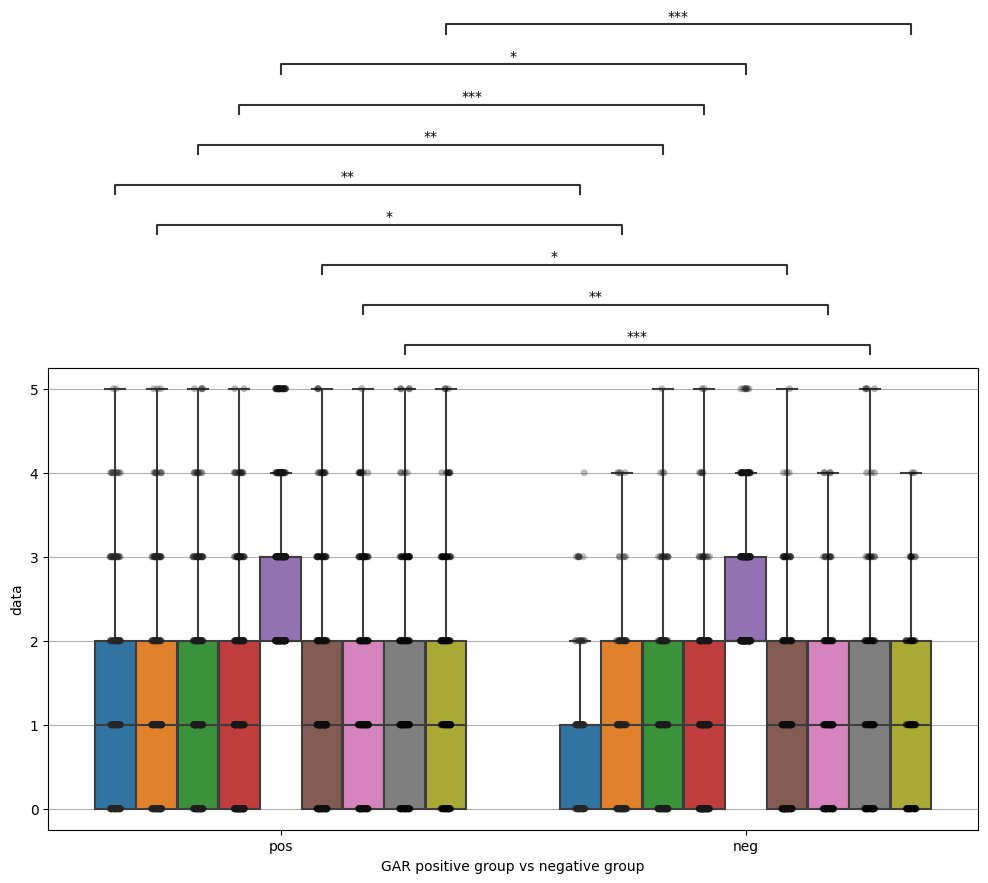

In [77]:
### boxplots, i want boxplots tat show the specific levels, across the categories
cut_data = protein_df_with_aa_metrics_cleaned[protein_df_with_aa_metrics_cleaned['aa'] == "R"]
chosen_metrics = ten_step_list
condition_2 = cut_data['metric'].isin(chosen_metrics)
cut_data = cut_data[condition_2]
cut_data = cut_data[cut_data['data'] < 6]

fig, annotator  = create_boxplot_with_dots(cut_data, chosen_metrics, scatter=True)
fig.gca().legend([],[], frameon=False)
# fig.gca().set(ylim=(0, 5))
fig

A6NEQ0
P98179
Q7Z6E9
O75526
P0DJD3
A6NDE4
P67809
P38159
P0C7P1
Q15415
P0DJD4
P62995
Q14444
Q13595
P35637
Q96E39
Q14011
Q99954
Q9BRL6


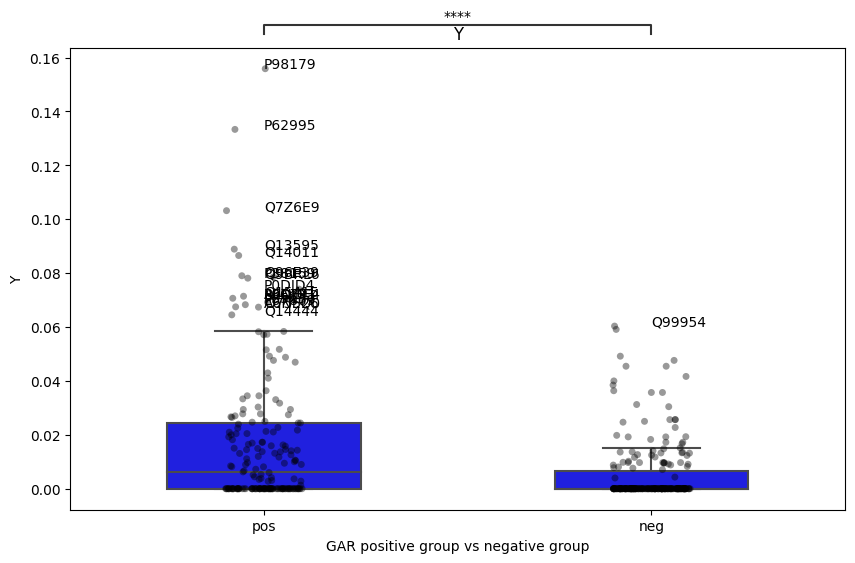

In [19]:
# This reforms the dict and creates singular graphs to take a closer look at the proteins in these groups
# new_df
new_dict = {}
for catkey in ['density_in_motif_IDR']:
    for protkey in protein_dict_with_aa_metrics.keys():
        # print(protkey)
        new_dict[protkey] = {}
        for aakey in aa_all:
            # print(aakey)
            # print(protein_dict_with_aa_metrics[protkey][aakey][catkey])
            new_dict[protkey][aakey] = protein_dict_with_aa_metrics[protkey][aakey][catkey]
# new_df = pd.DataFrame(new_dict).transpose()
# new_df
create_boxplot_with_dots(new_dict,"Y",pos_prot_list ,neg_prot_list, 0.06)

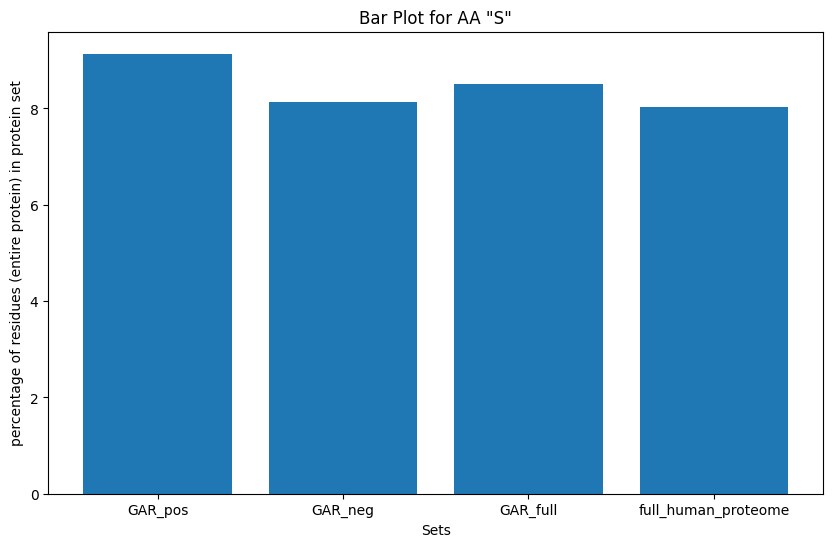

In [10]:
def plot_bars_for_key(df, aa, metric, protein_sets, labels):
    condition_1 = df['aa'] == aa
    condition_2 = df['metric'] == metric
    cut_data = df[condition_1 & condition_2]
    # print(protein_sets[0])
    # print(cut_data)
    values = [(sum(cut_data[cut_data['prot'].isin(prot_set)].data.tolist())/ len(cut_data[cut_data['prot'].isin(prot_set)].data.tolist())*100) for prot_set in protein_sets]

    # values = [(sum(dictionary[key])/len(dictionary[key])*100) for dictionary in dicts_list]
    fig = plt.figure(figsize=(10, 6))
    plt.bar(labels, values)
    plt.xlabel('Sets')
    plt.ylabel('percentage of residues (entire protein) in protein set')
    plt.title(f'Bar Plot for AA "{aa}"')
    
    # plt.show()
    plt.close()
    return fig




chosen_aas = list(protein_df_with_aa_metrics_cleaned.aa.unique())
chosen_metrics = ["density_overall"]
sets_here = [my_pos_group, my_neg_group, "GAR_full", "full_human_proteome"]

# Plotting each key as a separate bar plot
for aa in chosen_aas:
    for metric in chosen_metrics:
        fig = plot_bars_for_key(    
                            protein_df_with_aa_metrics_cleaned,
                            aa,
                            metric,
                            [set_list[set_names.index(_)] for _ in sets_here],
                            sets_here)
        fig.savefig(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/barplots_single_AA/' + "GAR_set_" + aa + "_" + metric + ".png")
        if aa == "S":
            fig_show = fig
fig_show

/tmp/ipykernel_300/1696181208.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['set'] = [set_name_] * len(temp_df)
/tmp/ipykernel_300/1696181208.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['set'] = [set_name_] * len(temp_df)
/tmp/ipykernel_300/1696181208.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

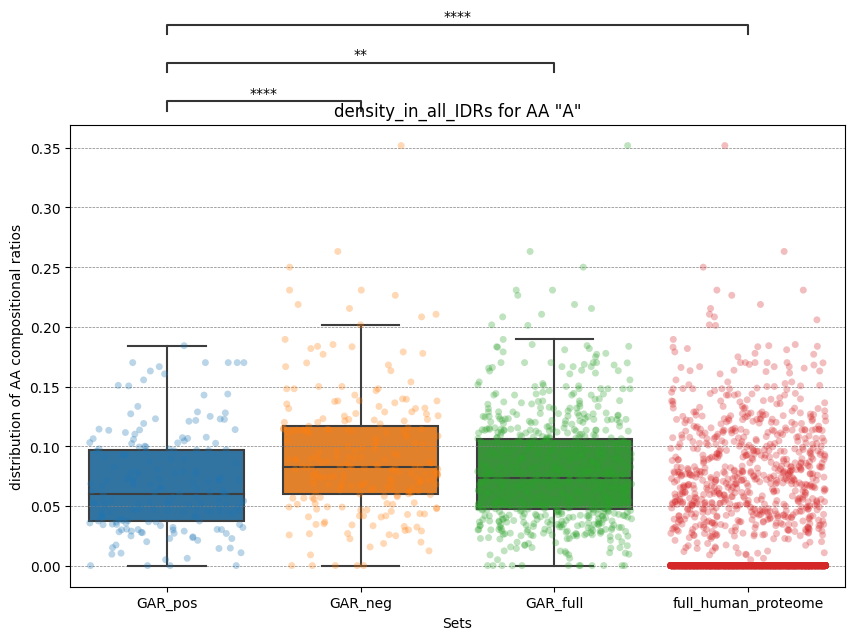

In [11]:
def plot_boxplots_for_key(df, aa, metric, protein_sets, labels):
    fig = plt.figure(figsize=(10, 6))
    condition_1 = df['aa'] == aa
    condition_2 = df['metric'] == metric
    cut_data = df[condition_1 & condition_2]
    # values = [dictionary[key] for dictionary in dicts_list]
    # df_data_dict = {'set': [], 'data': []}
    # for i,a in enumerate(values):
    #     for el in a:
    #         df_data_dict['set'].append(titles[i])
    #         df_data_dict['data'].append(el)
    #     # print(a)
    #     # print(len(a))
    # # print(len(values))
    
    # data = pd.DataFrame(df_data_dict)
    # print(data)
    list_of_temp_dfs = []
    for i, set_name_ in enumerate(labels):
        temp_df = cut_data[cut_data['prot'].isin(protein_sets[i])]
        temp_df['set'] = [set_name_] * len(temp_df)
        list_of_temp_dfs.append(temp_df)
    adapted_df = pd.concat(list_of_temp_dfs)
    box_pairs_allowed = [(labels[0],a) for a in labels[1:]]
    plt.gca().grid(True, which='both', linestyle='--', color='gray', linewidth=0.5, zorder=0)
    sns.boxplot(x='set', y='data', data=adapted_df, showfliers=False)
    sns.stripplot(x='set', y='data', data=adapted_df, alpha=0.3, jitter=0.4)
    a = add_stat_annotation(plt.gca(),  data=adapted_df,
                                        x="set",
                                        y="data",
                                        box_pairs=box_pairs_allowed,
                                        test='t-test_ind',
                                        text_format='star',
                                        verbose=0,
                                        loc='outside'
                                        )
    plt.xlabel('Sets')
    plt.ylabel('distribution of AA compositional ratios')
    plt.title(f'{metric} for AA "{aa}"')

    plt.close()
    return fig, a, adapted_df



sets_here = [my_pos_group, my_neg_group, "GAR_full", "full_human_proteome"]
# chosen_aas = list(set().union(*list_of_aa_ratio_dicts))
chosen_aas = ["A"]
chosen_metrics = ["density_in_all_IDRs"] #"density_overall", 'density_outside_IDR', 'density_in_all_IDRs', 'density_in_other_IDRs', 'density_in_motif_IDR'

# Plotting each key as a separate bar plot
for aa in chosen_aas:
    for metric in chosen_metrics:
        fig, a, int_df = plot_boxplots_for_key( protein_df_with_aa_metrics_cleaned,
                                        aa,
                                        metric,
                                        [set_list[set_names.index(_)] for _ in sets_here],
                                        sets_here)
        # fig.savefig(r'/mnt/d/phd/scripts/2_feature_correlation/outputs/AA_overview/boxplots_single_AA/' + "GAR_set_" + aa + "_" + metric + ".png", bbox_inches="tight")
        if aa == "A":
            fig_show = fig
fig_show


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

def calculate_aa_percentage(sequence, aa_list):
    """Computes the percentage of each amino acid in the given sequence."""
    counts = Counter(sequence)
    total = len(sequence) if sequence else 1  # Avoid division by zero
    return {aa: (counts[aa] / total) * 100 for aa in aa_list}

def compute_proportions(sequences, amino_acids, scope):
    """Computes amino acid proportions at each position with sliding window."""
    aa_percentages = {aa: [] for aa in amino_acids}
    
    for i in range(min(scope, 1), max(scope, -1) + 1):
        if scope > 0:
            # print(i)
            merged_seq = list(chain.from_iterable(lst[i-1:i+3] for lst in sequences))
        elif scope < 0:
            merged_seq = list(chain.from_iterable(lst[i-4:i] for lst in sequences))
            # print(sequences)
        
            # print(sequences[0][i-1:i])
        
        # if scope == 100:
        #     print(merged_seq)
        proportions = calculate_aa_percentage(merged_seq, amino_acids)
        # if scope == 100:
        #     print(proportions)
        for aa in amino_acids:
            aa_percentages[aa].append(proportions.get(aa, 0))
    
    return aa_percentages

def plot_aa_proportion(pre_pos, post_pos, pre_neg, post_neg, amino_acids, ref_props, ylim_values=None, scope=100):
    """Plots amino acid proportions in separate subplots for positive and negative sequences."""
    pre_pos_proportions = compute_proportions(pre_pos, amino_acids, -scope)
    post_pos_proportions = compute_proportions(post_pos, amino_acids, scope)
    pre_neg_proportions = compute_proportions(pre_neg, amino_acids, -scope)
    post_neg_proportions = compute_proportions(post_neg, amino_acids, scope)
    
    fig, axes = plt.subplots(len(amino_acids), 1, figsize=(10, 3 * len(amino_acids)), sharex=False)
    
    for ax, aa in zip(axes, amino_acids):
        pre_x = list(range(-len(pre_pos_proportions[aa]) + 1, 1))
        post_x = list(range(1, len(post_pos_proportions[aa]) + 1))
        
        ax.plot(pre_x, pre_pos_proportions[aa], marker="s", linestyle="-", color='#8DB600', label="Pre-Motif (Pos)")
        ax.plot([p + 1 for p in post_x], post_pos_proportions[aa], marker="s", linestyle="-", color='#8DB600', label="Post-Motif (Pos)")
        
        ax.plot(pre_x, pre_neg_proportions[aa], marker="s", linestyle="--", color='#FF4040', label="Pre-Motif (Neg)")
        ax.plot([p + 1 for p in post_x], post_neg_proportions[aa], marker="s", linestyle="--", color='#FF4040', label="Post-Motif (Neg)")
        
        if aa in ref_props:
            ax.axhline(ref_props[aa], color="black", linestyle="dotted", label=f"Avg {aa} in Disordered Regions")
        
        ax.set_ylabel(f"Proportion of {aa} (%)")
        # ax.legend()
        ax.grid(True)
        
        if ylim_values and aa in ylim_values:
            ax.set_ylim(ylim_values[aa])
    
    plt.xlabel("Position Relative to Motif")
    plt.xlim(-scope,scope)
    # plt.suptitle("Amino Acid Proportion at Each Position Around the Motif (Pos vs Neg)")
    plt.tight_layout()
    plt.show()

# Example usage:
selected_aas = ["Y", "N", "F", "M", "D", "K", "R", "G", "P", "L", "A", "C", "W"]  # Modify this list as needed
ref_y_props = {"Y": 5, "F": 3, "R": 8, "G": 5}  # Example reference values
ylim_manual = {"Y": (0, 5), "F": (0, 5), "R": (0, 25), "G": (0, 25)}  # Example manual Y-axis limits
# print(all_pos_post_seqs[:10])
plot_aa_proportion(all_pos_pre_seqs, all_pos_post_seqs, all_neg_pre_seqs, all_neg_post_seqs, selected_aas, ref_y_props, ylim_manual, 75)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

def calculate_aa_percentage(sequence, aa_list):
    """Computes the percentage of each amino acid in the given sequence."""
    counts = Counter(sequence)
    total = len(sequence) if sequence else 1  # Avoid division by zero
    return {aa: (counts[aa] / total) * 100 for aa in aa_list}

def compute_proportions(sequences, amino_acids, scope):
    """Computes amino acid proportions and standard error at each position."""
    aa_percentages = {aa: [] for aa in amino_acids}
    aa_stddev = {aa: [] for aa in amino_acids}
    aa_counts = {aa: [] for aa in amino_acids}

    for i in range(min(scope, 1), max(scope, -1) + 1):
        if scope > 0:
            merged_seqs = [lst[i-1:i+3] for lst in sequences if len(lst) > i+2]
        else:
            merged_seqs = [lst[i-4:i] for lst in sequences if len(lst) > abs(i)]

        merged_seqs_flat = list(chain.from_iterable(merged_seqs))
        proportions_list = [calculate_aa_percentage(seq, amino_acids) for seq in merged_seqs]

        avg_props = {aa: np.mean([p.get(aa, 0) for p in proportions_list]) for aa in amino_acids}
        stddevs = {aa: np.std([p.get(aa, 0) for p in proportions_list]) for aa in amino_acids}
        counts = {aa: max(1, len(proportions_list)) for aa in amino_acids}  # Avoid division by zero

        for aa in amino_acids:
            aa_percentages[aa].append(avg_props.get(aa, 0))
            aa_stddev[aa].append(stddevs[aa])
            aa_counts[aa].append(counts[aa])

    return aa_percentages, aa_stddev, aa_counts

def plot_aa_proportion(pre_pos, post_pos, pre_neg, post_neg, amino_acids, ref_props, ylim_values=None, scope=100):
    """Plots amino acid proportions with error bars in separate subplots for positive and negative sequences."""
    pre_pos_props, pre_pos_stddev, pre_pos_counts = compute_proportions(pre_pos, amino_acids, -scope)
    post_pos_props, post_pos_stddev, post_pos_counts = compute_proportions(post_pos, amino_acids, scope)
    pre_neg_props, pre_neg_stddev, pre_neg_counts = compute_proportions(pre_neg, amino_acids, -scope)
    post_neg_props, post_neg_stddev, post_neg_counts = compute_proportions(post_neg, amino_acids, scope)

    fig, axes = plt.subplots(len(amino_acids), 1, figsize=(10, 3 * len(amino_acids)), sharex=False)

    for ax, aa in zip(axes, amino_acids):
        pre_x = np.array(range(-len(pre_pos_props[aa]) + 1, 1))
        post_x = np.array(range(1, len(post_pos_props[aa]) + 1))

        # Compute SEM = standard deviation / sqrt(count)
        pre_pos_sem = np.array(pre_pos_stddev[aa]) / np.sqrt(np.array(pre_pos_counts[aa]))
        post_pos_sem = np.array(post_pos_stddev[aa]) / np.sqrt(np.array(post_pos_counts[aa]))
        pre_neg_sem = np.array(pre_neg_stddev[aa]) / np.sqrt(np.array(pre_neg_counts[aa]))
        post_neg_sem = np.array(post_neg_stddev[aa]) / np.sqrt(np.array(post_neg_counts[aa]))

        # Scale SEM if too small (Optional)
        # # scale_factor = 3  # Adjust for better visualization if needed
        # pre_pos_sem *= scale_factor
        # post_pos_sem *= scale_factor
        # pre_neg_sem *= scale_factor
        # post_neg_sem *= scale_factor

        # Plot with error bars
        ax.errorbar(pre_x, pre_pos_props[aa], yerr=pre_pos_sem, marker="o", linestyle="-", color='#8DB600', label="Pre-Motif (Pos)", capsize=3)
        ax.errorbar(post_x + 1, post_pos_props[aa], yerr=post_pos_sem, marker="o", linestyle="-", color='#8DB600', capsize=3)

        ax.errorbar(pre_x, pre_neg_props[aa], yerr=pre_neg_sem, marker="o", linestyle="--", color='#FF4040', label="Pre-Motif (Neg)", capsize=3)
        ax.errorbar(post_x + 1, post_neg_props[aa], yerr=post_neg_sem, marker="o", linestyle="--", color='#FF4040', capsize=3)

        # Alternative: Use shaded error region for visibility
        # ax.fill_between(pre_x, np.array(pre_pos_props[aa]) - pre_pos_sem, np.array(pre_pos_props[aa]) + pre_pos_sem, color='#8DB600', alpha=0.3)
        # ax.fill_between(post_x + 1, np.array(post_pos_props[aa]) - post_pos_sem, np.array(post_pos_props[aa]) + post_pos_sem, color='#8DB600', alpha=0.3)

        # ax.fill_between(pre_x, np.array(pre_neg_props[aa]) - pre_neg_sem, np.array(pre_neg_props[aa]) + pre_neg_sem, color='#FF4040', alpha=0.3)
        # ax.fill_between(post_x + 1, np.array(post_neg_props[aa]) - post_neg_sem, np.array(post_neg_props[aa]) + post_neg_sem, color='#FF4040', alpha=0.3)

        if aa in ref_props:
            ax.axhline(ref_props[aa], color="black", linestyle="dotted", label=f"Avg {aa} in Disordered Regions")

        ax.set_ylabel(f"Proportion of {aa} (%)")
        ax.grid(True)

        if ylim_values and aa in ylim_values:
            ax.set_ylim(ylim_values[aa])

    plt.xlabel("Position Relative to Motif")
    plt.xlim(-scope, scope)
    plt.tight_layout()
    plt.show()

# Example usage:
selected_aas = ["Y", "N", "F", "M", "D", "K", "R", "G", "P", "L", "A", "C", "W"]
ref_y_props = {"Y": 5, "F": 3, "R": 8, "G": 5}
ylim_manual = {"Y": (0, 5), "F": (0, 5), "R": (0, 25), "G": (0, 25)}

plot_aa_proportion(all_pos_pre_seqs, all_pos_post_seqs, all_neg_pre_seqs, all_neg_post_seqs, selected_aas, ref_y_props, ylim_manual, 50)


In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(pos_dict, neg_dict, bins=100, letters = "all"):
    if letters == "all":
        letters = pos_dict.keys()
    fig, axes = plt.subplots(nrows=len(letters), ncols=1, figsize=(15, 50), sharex=False, sharey=False)

    for ax, letter in zip(axes, letters):
        # print(pos_dict[letter])
        pos_data = [d for lst in pos_dict[letter] for d in lst if abs(d) < scope]  # Flatten lists
        neg_data = [d for lst in neg_dict[letter] for d in lst if abs(d) < scope]  # Flatten lists
        # print(len(pos_data))
        num_pos_entries = len(pos_dict[letter])  # Number of data entries
        num_neg_entries = len(neg_dict[letter])  

        # ax_kde = ax.twinx()
        ax.hist(neg_data, bins=bins, alpha=0.5, label="Neg", color='#FF4040', density=False, edgecolor="black")
        ax.hist(pos_data, bins=bins,alpha = 0.5, label="Pos", color='#8DB600', density=False, edgecolor="black") 

    # KDE Plot (smoothed density estimation)
        # sns.kdeplot(pos_data, bw_adjust=0.05, color='#8DB600', ax=ax_kde, linestyle="-", label="Pos KDE")
        # sns.kdeplot(neg_data, bw_adjust=0.05, color='#FF4040', ax=ax_kde, linestyle="-", label="Neg KDE")


        ax.axvline(0, color="black", linestyle="--")  # Mark region boundary
        ax.set_title(f"Letter {letter}")
        ax.set_xlabel("Distance")
        ax.set_xticks(np.arange(bins[0]+1/len(bins), bins[-1]+1/len(bins), len(bins)/5))
    
    axes[0].set_ylabel("Density")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# ,width=0.9*(bins[-1]-bins[-2]), , weights=np.ones(len(neg_data)) / num_neg_entries
# ,width=0.9*(bins[-1]-bins[-2]),


# Run the plot

scope = 100

# bins = np.arange(-1.005, 1.005 + 0.01, 0.07)
bins = np.arange(-scope -0.5, scope + 0.5, scope/25)
# print(bins)

letters = ["Y", "N", "F", "M", "D", "K", "R", "V", "P", "L", "A", "C", "W"]

plot_histograms(pos_new_dict, neg_new_dict, bins=bins, letters = letters)